## 01 Graphic - Attributed GMT

In [1]:
from pathlib import Path
import os
import sys
sys.path.append(os.path.abspath(''))

import pandas as pd 
import numpy as np
import geopandas as gpd 
from shapely import box
import pycountry

from tqdm.notebook import tqdm

import config.config as cfg 
from config.config import (MAGICC_OUTPUT_FILES, 
                           WID_DATA_DIR,
                            WID_DATA_PROCESSED,
                           GRAPHICS_DIR,
                           fontsize_medium,
                           fontsize_small,
                           fontsize_large
                           )

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec

MAGICC_OUTPUT_FILE = MAGICC_OUTPUT_FILES[0]

/Users/schoens/Documents/PhD/IIASA/05_Data


In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

path_output = '/Users/schoens/Documents/PhD/IIASA/06_Graphics/Presentation/'

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [3]:
sel_columns      = ['climate_model', 'model', 'region', 'run_id', 'scenario', 'unit', 'variable'] + [f'{int(iter)}-01-01 00:00:00' for iter in np.arange(1800, 2021,1)]

dfs = []
for i in tqdm(range(6), total = 6):
    df = pd.read_csv(MAGICC_OUTPUT_FILES[i])
    if i != 0: 
        df = df[df.scenario != 'ssp245']
    df = df[df.variable == 'Surface Air Temperature Change'].loc[:, sel_columns]
    dfs.append(df)

magicc_output_df = pd.concat(dfs, ignore_index=True)
# pd.read_csv(MAGICC_OUTPUT_FILE)
# magicc_output_df = magicc_output_df[magicc_output_df.variable == 'Surface Air Temperature Change'].loc[:, sel_columns]

#re-center to 1850-1900
# Select the columns corresponding to the reference period 1850-1900
reference_period = pd.date_range(start='1850-01-01', end='1900-01-01', freq='YS')
reference_cols   = [col for col in magicc_output_df.columns if col in reference_period.strftime('%Y-%m-%d %H:%M:%S')]

# Function to recenter data based on the reference period
def recenter_row(row):
    reference_mean = row[reference_cols].mean()
    return row[7:] - reference_mean  # Assuming the first 7 columns are non-numeric metadata

# Apply the function to recenter each row
numeric_cols = magicc_output_df.columns[7:]  # Assuming numeric data starts from the 8th column
magicc_output_df[numeric_cols] = magicc_output_df.apply(recenter_row, axis=1)
magicc_output_df[numeric_cols] *= 0.85*1/(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00':'2014-01-01 00:00:00'].mean().mean())
# *0.85

  0%|          | 0/6 [00:00<?, ?it/s]

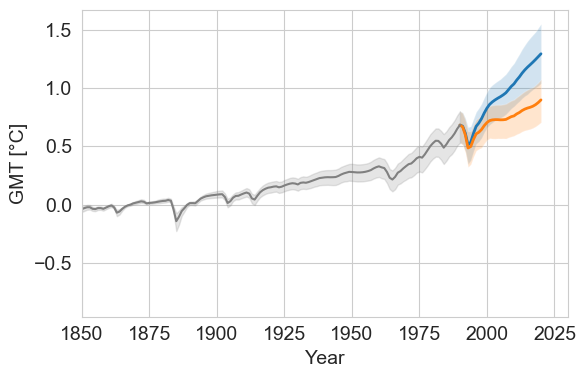

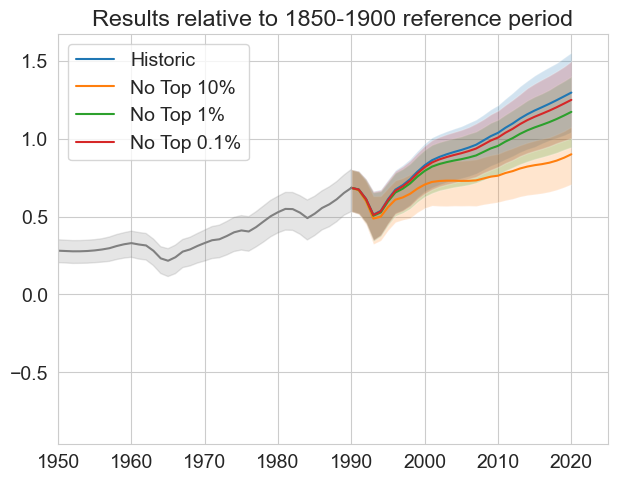

In [4]:
color_map = dict(zip(['ssp245', 'World_p90p100_equal-scaling', 'World_p99p100_equal-scaling', 'World_p999p100_equal-scaling'], ['C0', 'C1', 'C2', 'C3']))
label_map = dict(zip(['ssp245', 'World_p90p100_equal-scaling', 'World_p99p100_equal-scaling', 'World_p999p100_equal-scaling'], ['Historic', 'No Top 10%', 'No Top 1%', 'No Top 0.1%']))

with sns.axes_style('whitegrid'):
    plt.figure(figsize =(6,4))
    for scenario in list(color_map.keys())[:2]:
        sub_df = magicc_output_df[magicc_output_df.scenario == scenario]
        plt.fill_between(np.arange(1990,2021,1), np.quantile(sub_df.iloc[:, 7:].values.T[190:,:], q = 0.05, axis = 1), np.quantile(sub_df.iloc[:, 7:].values.T[190:,:], q = 0.95, axis = 1), alpha = .2)
        plt.plot(np.arange(1990,2021,1), np.mean(sub_df.iloc[:, 7:].values.T[190:,:], axis = 1), color = color_map[scenario], label = label_map[scenario], lw = 2)
        
        # plt.plot(np.arange(1990,2021,1), sub_df.iloc[:, 7:].values.T[190:,0], color = color_map[scenario], label = label_map[scenario])
        # plt.plot(np.arange(1990,2021,1), sub_df.iloc[:, 7:].values.T[190:,:], color = color_map[scenario], alpha = .2)
    plt.fill_between(np.arange(1800,1991,1), np.quantile(sub_df.iloc[:, 7:].values.T[:191,:], q = 0.05, axis = 1), np.quantile(sub_df.iloc[:, 7:].values.T[:191,:], q = 0.95, axis = 1), alpha = .2, color = 'grey')
    plt.plot(np.arange(1800,1991,1), np.mean(sub_df.iloc[:, 7:].values.T[:191,:], axis = 1), color = 'grey')
    plt.xlim(1850, 2030)
    # plt.legend()
    # plt.title('Results relative to 1850-1900 reference period')
    plt.ylabel('GMT [°C]')
    plt.xlabel('Year')
    plt.tight_layout()
    plt.savefig(path_output + 'gmt_results.png', dpi = 600)
    plt.show()
    
color_map = dict(zip(['ssp245', 'World_p90p100_equal-scaling', 'World_p99p100_equal-scaling', 'World_p999p100_equal-scaling'], ['C0', 'C1', 'C2', 'C3']))
label_map = dict(zip(['ssp245', 'World_p90p100_equal-scaling', 'World_p99p100_equal-scaling', 'World_p999p100_equal-scaling'], ['Historic', 'No Top 10%', 'No Top 1%', 'No Top 0.1%']))

with sns.axes_style('whitegrid'):
    plt.figure()
    for scenario in color_map.keys():
        sub_df = magicc_output_df[magicc_output_df.scenario == scenario]
        plt.fill_between(np.arange(1990,2021,1), np.quantile(sub_df.iloc[:, 7:].values.T[190:,:], q = 0.05, axis = 1), np.quantile(sub_df.iloc[:, 7:].values.T[190:,:], q = 0.95, axis = 1), alpha = .2)
        plt.plot(np.arange(1990,2021,1), np.mean(sub_df.iloc[:, 7:].values.T[190:,:], axis = 1), color = color_map[scenario], label = label_map[scenario])
        
        # plt.plot(np.arange(1990,2021,1), sub_df.iloc[:, 7:].values.T[190:,0], color = color_map[scenario], label = label_map[scenario])
        # plt.plot(np.arange(1990,2021,1), sub_df.iloc[:, 7:].values.T[190:,:], color = color_map[scenario], alpha = .2)
    plt.fill_between(np.arange(1800,1991,1), np.quantile(sub_df.iloc[:, 7:].values.T[:191,:], q = 0.05, axis = 1), np.quantile(sub_df.iloc[:, 7:].values.T[:191,:], q = 0.95, axis = 1), alpha = .2, color = 'grey')
    plt.plot(np.arange(1800,1991,1), np.mean(sub_df.iloc[:, 7:].values.T[:191,:], axis = 1), color = 'grey')
    plt.xlim(1950, 2025)
    plt.legend()
    plt.tight_layout()
    plt.title('Results relative to 1850-1900 reference period')
    plt.show()

### Regional Attribution Results

In [5]:
# regions = ['CN', 'IN', 'EU27', 'US']
regions = ['US', 'EU27', 'IN', 'CN']
region_names = {'CN': 'China', 
                'IN': 'India',
                'EU27': 'EU27',
                'US': 'USA'}

# ! modify shares
shares = [0.0449, 0.0616, 0.170, 0.206]

cmap = matplotlib.cm.get_cmap('viridis')
# colors = ['lightgray'] + [cmap(i) for i in np.linspace(0,1,5)]
colors = ['lightgray'] + ['coral', lighten_color('teal', 0.95), lighten_color('mediumvioletred', 0.95), 'rebeccapurple']

colors = ['darkgray', 
        [1.        , 0.56862745, 0.40915033, 1.        ], 
        [0.38065359, 0.59686275, 0.59686275, 1.        ],
        [0.80915033, 0.41568627, 0.63137255, 1.        ]]

# colors = ['lightgray', 'C1', 'C2', 'C3', 'C5', 'C4'] 
lighter_colors = [lighten_color(color, 0.2) for color in colors]

uncertainty_color = 'black'
sensitvitiy_color = 'saddlebrown'
symbols = ["o", 's', '*', 'D']

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_5491/2671597710.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


#### Combine everything into a single graphic

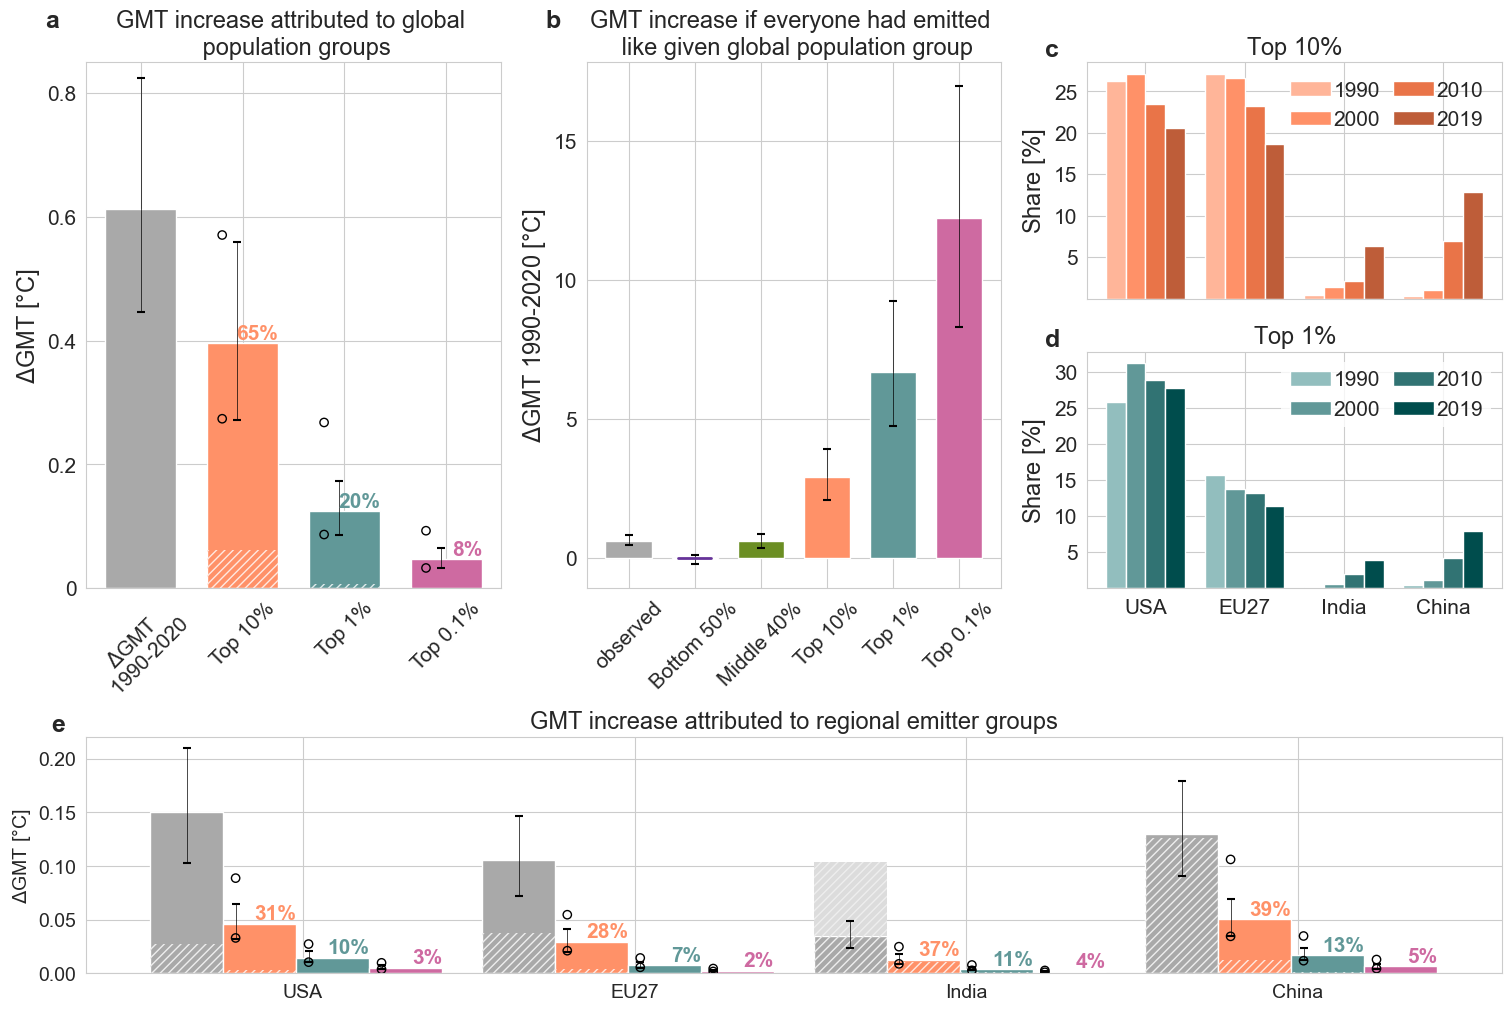

In [24]:
lettering = ['a', 'b', 'e', 'c', 'd'] 

with sns.axes_style('whitegrid'):
    fig = plt.figure(layout="constrained", figsize = (15,10))
    gs = GridSpec(3, 3, figure=fig)
    axes = []
    
    ### first graphics 
    ax = fig.add_subplot(gs[:2, 0])
    colors = ['darkgray', 
        [1.        , 0.56862745, 0.40915033, 1.        ], 
        [0.38065359, 0.59686275, 0.59686275, 1.        ],
        [0.80915033, 0.41568627, 0.63137255, 1.        ]]

    # colors = ['lightgray', 'C1', 'C2', 'C3', 'C5', 'C4'] 
    lighter_colors = [lighten_color(color, 0.2) for color in colors]
    delta_gmt = magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean()
    group_deltas = []
    for group in ['p80p100', 'p90p100', 'p99p100', 'p999p100']:
        group_deltas.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == f'World_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
        
    group_deltas_fair = [delta_gmt*i for i in [0.2, 0.1, 0.01, 0.001]]

    delta_gmt_range = (magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00']-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00']).quantile([0.05, 0.95]).values
    group_deltas_low = []
    group_deltas_hi = []
    for group in ['p80p100', 'p90p100', 'p99p100', 'p999p100']:
        group_deltas_low.append(np.quantile((magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_output_df[magicc_output_df.scenario == f'World_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].values), q = 0.05))
        group_deltas_hi.append(np.quantile((magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_output_df[magicc_output_df.scenario == f'World_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].values), q = 0.95))

    group_deltas_sensitivitiy_low = []
    group_deltas_sensitivitiy_hi = []
    for group in ['p80p100', 'p90p100', 'p99p100', 'p999p100']:
        group_deltas_sensitivitiy_low.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == f'World_{group}_CO2-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
        group_deltas_sensitivitiy_hi.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()- magicc_output_df[magicc_output_df.scenario == f'World_{group}_CH4-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
        
    bar1 = ax.bar([0,1,2,3], [delta_gmt]+group_deltas[1:], width = 0.7, color = colors)
    bar2 = ax.bar([1,2,3], group_deltas_fair[1:], width = 0.7, color = 'none', edgecolor = lighter_colors[1:], hatch = 2*'//', 
                  lw = 0)
    
    ax.vlines(0, delta_gmt_range[0], delta_gmt_range[1], color = uncertainty_color, lw = 0.5)
    for i in range(3): 
        ax.vlines(i+1-0.05, group_deltas_low[i+1], group_deltas_hi[i+1], color = uncertainty_color, lw = 0.5)
        
    ax.scatter(0, [delta_gmt_range[0]], color = uncertainty_color, marker = '_')
    ax.scatter(0, [delta_gmt_range[1]], color = uncertainty_color, marker = '_')
    
    ax.scatter(np.array([1,2,3])-0.05, group_deltas_low[1:], color = uncertainty_color, marker = '_')
    ax.scatter(np.array([1,2,3])-0.05, group_deltas_hi[1:], color = uncertainty_color, marker = '_')
    
    ax.scatter(np.array([1,2,3])-0.2, group_deltas_sensitivitiy_low[1:], color = uncertainty_color, marker = 'o', facecolors='none')
    ax.scatter(np.array([1,2,3])-0.2, group_deltas_sensitivitiy_hi[1:], color = uncertainty_color, marker = 'o', facecolors='none')
    
    # Add counts above the two bar graphs
    i_bar = 0 
    for rect in bar1:
        if i_bar == 0:
            i_bar += 1
            continue
        else: 
            height = rect.get_height()
            ratio  = np.round(group_deltas[:][i_bar]/delta_gmt*100,2)
            ax.text(rect.get_x() + rect.get_width(), height, f'{ratio:.0f}%', 
                    ha='right', 
                    va='bottom', 
                    color = colors[i_bar],
                    fontsize = fontsize_medium,
                    weight = 'bold'
                    )
            i_bar += 1
            
    ax.set_ylabel('$\Delta$GMT [°C]', 
                  fontsize = fontsize_large)
    ax.set_yticks([0, 0.2,0.4, 0.6, 0.8],
                  [0, 0.2, 0.4, 0.6, 0.8],
                  fontsize = fontsize_medium)
    ax.set_xticks([0,1,2,3], ['$\Delta$GMT \n 1990-2020', 'Top 10%', 'Top 1%', 'Top 0.1%'], 
                  rotation = 45,
                  fontsize = fontsize_medium
                  )
    ax.set_ylim(0,0.85)
    ax.set_title('GMT increase attributed to global \n population groups', fontsize = fontsize_large)
    axes.append(ax)

    ax = fig.add_subplot(gs[:2, 1])
    colors = ['darkgray'] + ['rebeccapurple', 
                           'olivedrab',
                          [1.        , 0.56862745, 0.40915033, 1.        ], 
                          [0.38065359, 0.59686275, 0.59686275, 1.        ],
                          [0.80915033, 0.41568627, 0.63137255, 1.        ]
                          ]

    # colors = ['lightgray', 'C1', 'C2', 'C3', 'C5', 'C4'] 
    lighter_colors = [lighten_color(color, 0.5) for color in colors]
    
    delta_gmt  = magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean()
    delta_gmts = []
    delta_gmts_low = []
    delta_gmts_high = []
    for group in ['p0p50', 'p50p90', 'p90p100', 'p99p100', 'p999p100']:
        delta_gmts.append(magicc_output_df[magicc_output_df.scenario == f'everyon-like_World_{group}'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean())
        delta_gmts_low.append(np.quantile(magicc_output_df[magicc_output_df.scenario == f'everyon-like_World_{group}'].loc[:, '2020-01-01 00:00:00'].values- magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean(), q = 0.05))
        delta_gmts_high.append(np.quantile(magicc_output_df[magicc_output_df.scenario == f'everyon-like_World_{group}'].loc[:, '2020-01-01 00:00:00'].values- magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean(), q = 0.95))

    regional_gmt = []
    for region in regions:
        gmt_tmp = []
        for group in ['p0p50', 'p50p90', 'p90p100', 'p99p100', 'p999p100']:
            gmt_tmp.append(magicc_output_df[magicc_output_df.scenario == f'everyon-like_{region}_{group}'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean())
        regional_gmt.append(gmt_tmp)

    bar1 = ax.bar([0,1,2,3,4,5], [delta_gmt]+delta_gmts, width = 0.7, color = colors)
    
    ax.vlines(0, delta_gmt_range[0], delta_gmt_range[1], color = uncertainty_color, lw = 0.5)
    for i in range(5): 
        ax.vlines(i+1, delta_gmts_low[i], delta_gmts_high[i], color = uncertainty_color, lw = 0.5)
    
    plt.plot([0.75,1.25], [0,0], color = 'rebeccapurple', lw = 2)
        
    ax.scatter(0, [delta_gmt_range[0]], color = uncertainty_color, marker = '_')
    ax.scatter(0, [delta_gmt_range[1]], color = uncertainty_color, marker = '_')
    
    ax.scatter(np.array([1,2,3,4,5]), delta_gmts_low[:], color = uncertainty_color, marker = '_')
    ax.scatter(np.array([1,2,3,4,5]), delta_gmts_high[:], color = uncertainty_color, marker = '_')
    
    # for i_region in range(len(regions)):
    #     ax.scatter(np.array([1,2,3,4,5]), regional_gmt[i_region], color = lighter_colors[1:], marker = symbols[i_region], facecolors=lighter_colors[1:])

    ax.set_ylabel('$\Delta$GMT 1990-2020 [°C]', 
                  fontsize  = fontsize_large)
    ax.set_xticks([0,1,2,3,4,5], 
                  ['observed', 'Bottom 50%', 'Middle 40%', 'Top 10%', 'Top 1%', 'Top 0.1%'], 
                  rotation = 45, 
                  fontsize = fontsize_medium)
    ax.set_yticks([0,5,10,15], 
                  [0,5,10,15], 
                  fontsize = fontsize_medium)
    ax.set_title('GMT increase if everyone had emitted \n like given global population group', fontsize = fontsize_large)
    axes.append(ax)

    ### third graphic 
    colors = ['darkgray', 
        [1.        , 0.56862745, 0.40915033, 1.        ], 
        [0.38065359, 0.59686275, 0.59686275, 1.        ],
        [0.80915033, 0.41568627, 0.63137255, 1.        ]]

    # colors = ['lightgray', 'C1', 'C2', 'C3', 'C5', 'C4'] 
    lighter_colors = [lighten_color(color, 0.2) for color in colors]
    ax = fig.add_subplot(gs[2, :3])
    for i_region in range(len(regions)):
        region = regions[i_region]
        share = shares[i_region]
        delta_gmt = magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean()
        group_deltas = []
        for group in ['p0p100', 'p90p100', 'p99p100', 'p999p100']:
            group_deltas.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
        
        group_deltas_fair = [delta_gmt*i*share for i in [1, 0.1, 0.01, 0.001]]
        
        delta_gmt_range = (magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00']-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00']).quantile([0.05, 0.95]).values
        delta_gmt_range = [gmt*share for gmt in delta_gmt_range]
        
        group_deltas_low = []
        group_deltas_hi = []
        for group in ['p0p100', 'p90p100', 'p99p100', 'p999p100']:
            group_deltas_low.append(np.quantile((magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].values), q = 0.05))
            group_deltas_hi.append(np.quantile((magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].values), q = 0.95))

        group_deltas_sensitivitiy_low = []
        group_deltas_sensitivitiy_hi = []
        for group in ['p0p100', 'p90p100', 'p99p100', 'p999p100']:
            group_deltas_sensitivitiy_low.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_CO2-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
            group_deltas_sensitivitiy_hi.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()- magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_CH4-scaling'].loc[:, '2020-01-01 00:00:00'].mean())

        width = 0.22
        start = 0.15
        loc_bar = np.array([start,start+width,start+width*2,start+width*3])+i_region

        bar1 = ax.bar(loc_bar, group_deltas[:], width = width, color = colors)
        if  group_deltas[0] < group_deltas_fair[0]:
            ax.bar(loc_bar[0], group_deltas_fair[0]-group_deltas[0], bottom = group_deltas[0], width = width, color = 'gainsboro', lw = 0)
        ax.bar(loc_bar, group_deltas_fair[:], width = width, color = 'none', edgecolor = lighter_colors[:], hatch = 2*'//', lw = 0)
        
        for i in range(4): 
            if i == 0:
                ax.vlines(loc_bar[i], group_deltas_low[i], group_deltas_hi[i], color = uncertainty_color, lw = 0.5)
                ax.scatter(loc_bar[i], group_deltas_low[i], color = uncertainty_color, marker = '_')
                ax.scatter(loc_bar[i], group_deltas_hi[i], color = uncertainty_color, marker = '_')
            else: 
                ax.vlines(loc_bar[i]-width/3, group_deltas_low[i], group_deltas_hi[i], color = uncertainty_color, lw = 0.5)
                
        ax.scatter(loc_bar[1:]-width/3, group_deltas_low[1:], color = uncertainty_color, marker = '_')
        ax.scatter(loc_bar[1:]-width/3, group_deltas_hi[1:], color = uncertainty_color, marker = '_')
        
        ax.scatter(loc_bar[1:]-width/3, group_deltas_sensitivitiy_low[1:], color = uncertainty_color, marker = 'o', facecolors='none')
        ax.scatter(loc_bar[1:]-width/3, group_deltas_sensitivitiy_hi[1:], color = uncertainty_color, marker = 'o', facecolors='none')
        
        i_bar = 0 
        for rect in bar1:
            if i_bar == 0:
                i_bar += 1
                continue
            else: 
                height = rect.get_height()
                ratio  = np.round(group_deltas[i_bar]/group_deltas[0]*100,2)
                ax.text(rect.get_x() + rect.get_width(), height, f'{ratio:.0f}%', 
                        ha='right', 
                        va='bottom', 
                        color = colors[i_bar],
                        fontsize = fontsize_medium,
                        weight = 'bold'
                        )
                i_bar += 1
        
        # ax.bar([1.2, 2.2, 3.2], group_deltas_fair, width = 0.4, color = ['orange', 'green', 'red'])

    ax.set_ylabel('$\Delta$GMT [°C]')
    ax.set_xticks([.5,1.5,2.5,3.5], [region_names[region] for region in regions], rotation = 0)
    ax.set_title('GMT increase attributed to regional emitter groups', fontsize = fontsize_large)
    
    axes.append(ax)
    
    ax = fig.add_subplot(gs[0, 2])
        
    sel_regions = ['USA', 'NLD', 'IND', 'CHN', 'JPN', 'GBR', 'CAN', 'BRA']
    EU27_ids = ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK']


    bar_graph_data = pd.read_csv(WID_DATA_PROCESSED / 'wealthy_by_location' / f'WID_WO_p90p100_data_bar_graph.csv', sep = ';', index_col = 0)

    colors = sns.color_palette("Oranges", as_cmap=True)(np.linspace(0.2,1,4))
    # colors = sns.color_palette("colorblind")
    colors = sns.color_palette("blend:#FFB599,#FF7F50,#BE5D39", as_cmap=True)(np.linspace(0,1,4))

    sel_bar_graph_data = bar_graph_data.iloc[:,:4]

    width = 0.2
    multiplier = 0
    position = np.arange(4)

    for i_year in range(4): 
        offset = width * multiplier
        ax.bar(position + offset, sel_bar_graph_data.iloc[i_year, :], width, color = colors[i_year], label = int(sel_bar_graph_data.index[i_year]))
        multiplier += 1
        
    ax.set_xticks(position + 1.5*width, 
                [])
    ax.set_yticks([5,10,15,20,25],
                [5,10,15,20,25], 
                fontsize = fontsize_medium)
    ax.set_ylabel('Share [$\%$]', fontsize = fontsize_large)
    ax.legend(ncols = 2, frameon = False, fontsize = fontsize_medium, columnspacing=0.6, handletextpad=0.1, edgecolor = 'none', facecolor=(1, 1, 1, 0.7))
    ax.set_title('Top 10$\%$', fontsize = fontsize_large)
    axes.append(ax)
    # fifth graphic 
    ax = fig.add_subplot(gs[1, 2])
    bar_graph_data = pd.read_csv(WID_DATA_PROCESSED / 'wealthy_by_location' / f'WID_WO_p99p100_data_bar_graph.csv', sep = ';', index_col = 0)

    colors = sns.color_palette("blend:#B6DADA,#004D4D", as_cmap=True)(np.linspace(0.2,1,4))

    sel_bar_graph_data = bar_graph_data.iloc[:,:4]
    multiplier = 0
    for i_year in range(4): 
        offset = width * multiplier
        ax.bar(position + offset, sel_bar_graph_data.iloc[i_year, :], width, color = colors[i_year], label = int(sel_bar_graph_data.index[i_year]))
        multiplier += 1
        
    ax.set_xticks(position + 1.5*width, 
                  ['USA', 'EU27', 'India', 'China'], 
                  fontsize = fontsize_medium)
    ax.set_yticks([5,10,15,20,25, 30],
                  [5,10,15,20,25, 30], 
                  fontsize = fontsize_medium)
    ax.set_ylabel('Share [$\%$]', fontsize = fontsize_large)
    ax.legend(ncols = 2, frameon = True, fontsize = fontsize_medium, columnspacing=0.6, handletextpad=0.1, edgecolor = 'none', facecolor=(1, 1, 1, 0.7))
    ax.set_title('Top 1$\%$', fontsize = fontsize_large)
    axes.append(ax)
    
    xs = [-0.1,-0.1,-0.025,-0.1,-0.1]
    ys = [1.1,1.1,1.1,1.1,1.1]
    for i in range(5):
        axes[i].text(xs[i], ys[i], lettering[i], transform=axes[i].transAxes, fontsize=fontsize_large+1, fontweight='bold', va='top')
    plt.savefig(GRAPHICS_DIR / 'paper' / 'V0' / '002_display_item.pdf', dpi = 600)
    plt.show()


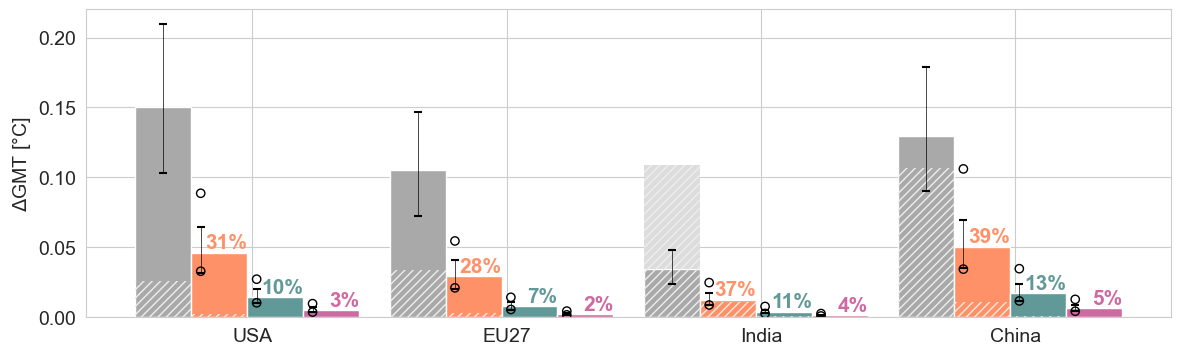

In [76]:
with sns.axes_style('whitegrid'):
    fig, axs = plt.subplots(1,1, figsize = (14,4))
    for i_region in range(len(regions)):
        region = regions[i_region]
        share = shares[i_region]
        delta_gmt = magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean()
        group_deltas = []
        for group in ['p0p100', 'p90p100', 'p99p100', 'p999p100']:
            group_deltas.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
        
        group_deltas_fair = [delta_gmt*i*share for i in [1, 0.1, 0.01, 0.001]]
        
        delta_gmt_range = (magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00']-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00']).quantile([0.05, 0.95]).values
        delta_gmt_range = [gmt*share for gmt in delta_gmt_range]
        
        group_deltas_low = []
        group_deltas_hi = []
        for group in ['p0p100', 'p90p100', 'p99p100', 'p999p100']:
            group_deltas_low.append(np.quantile((magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].values), q = 0.05))
            group_deltas_hi.append(np.quantile((magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].values), q = 0.95))

        group_deltas_sensitivitiy_low = []
        group_deltas_sensitivitiy_hi = []
        for group in ['p0p100', 'p90p100', 'p99p100', 'p999p100']:
            group_deltas_sensitivitiy_low.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_CO2-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
            group_deltas_sensitivitiy_hi.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()- magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_CH4-scaling'].loc[:, '2020-01-01 00:00:00'].mean())

        width = 0.22
        start = 0.15
        loc_bar = np.array([start,start+width,start+width*2,start+width*3])+i_region
    
        ax = axs
        
        bar1 = ax.bar(loc_bar, group_deltas[:], width = width, color = colors)
        if  group_deltas[0] < group_deltas_fair[0]:
            ax.bar(loc_bar[0], group_deltas_fair[0]-group_deltas[0], bottom = group_deltas[0], width = width, color = 'gainsboro', lw = 0)
        ax.bar(loc_bar, group_deltas_fair[:], width = width, color = 'none', edgecolor = lighter_colors[:], hatch = 2*'//', lw = 0)
        
        for i in range(4): 
            if i == 0:
                ax.vlines(loc_bar[i], group_deltas_low[i], group_deltas_hi[i], color = uncertainty_color, lw = 0.5)
                ax.scatter(loc_bar[i], group_deltas_low[i], color = uncertainty_color, marker = '_')
                ax.scatter(loc_bar[i], group_deltas_hi[i], color = uncertainty_color, marker = '_')
            else: 
                ax.vlines(loc_bar[i]-width/3, group_deltas_low[i], group_deltas_hi[i], color = uncertainty_color, lw = 0.5)
                
        ax.scatter(loc_bar[1:]-width/3, group_deltas_low[1:], color = uncertainty_color, marker = '_')
        ax.scatter(loc_bar[1:]-width/3, group_deltas_hi[1:], color = uncertainty_color, marker = '_')
        
        ax.scatter(loc_bar[1:]-width/3, group_deltas_sensitivitiy_low[1:], color = uncertainty_color, marker = 'o', facecolors='none')
        ax.scatter(loc_bar[1:]-width/3, group_deltas_sensitivitiy_hi[1:], color = uncertainty_color, marker = 'o', facecolors='none')
        
        i_bar = 0 
        for rect in bar1:
            if i_bar == 0:
                i_bar += 1
                continue
            else: 
                height = rect.get_height()
                ratio  = np.round(group_deltas[i_bar]/group_deltas[0]*100,2)
                ax.text(rect.get_x() + rect.get_width(), height, f'{ratio:.0f}%', 
                        ha='right', 
                        va='bottom', 
                        color = colors[i_bar],
                        fontsize = fontsize_medium,
                        weight = 'bold'
                        )
                i_bar += 1
        
        # ax.bar([1.2, 2.2, 3.2], group_deltas_fair, width = 0.4, color = ['orange', 'green', 'red'])

    ax.set_ylabel('$\Delta$GMT [°C]')
    ax.set_xticks([.5,1.5,2.5,3.5], [region_names[region] for region in regions], rotation = 0)
    # ax.set_title(f'{region_names[region]}')
    plt.show()
            
        
           

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_95945/542228523.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


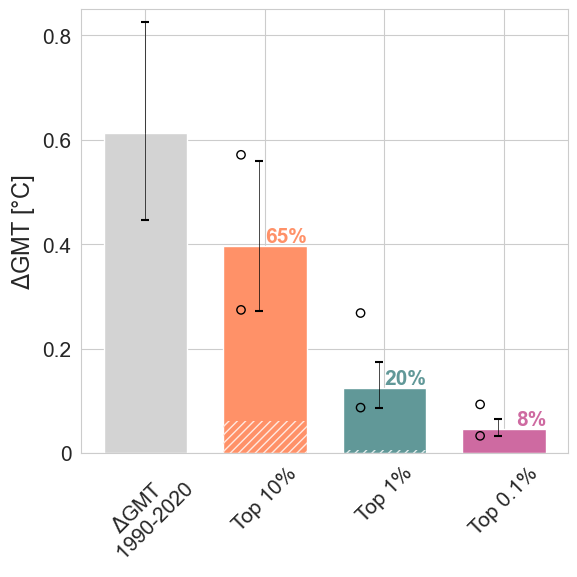

In [125]:
delta_gmt = magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean()
group_deltas = []
for group in ['p80p100', 'p90p100', 'p99p100', 'p999p100']:
    group_deltas.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == f'World_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
    
group_deltas_fair = [delta_gmt*i for i in [0.2, 0.1, 0.01, 0.001]]

delta_gmt_range = (magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00']-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00']).quantile([0.05, 0.95]).values
group_deltas_low = []
group_deltas_hi = []
for group in ['p80p100', 'p90p100', 'p99p100', 'p999p100']:
    group_deltas_low.append(np.quantile((magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_output_df[magicc_output_df.scenario == f'World_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].values), q = 0.05))
    group_deltas_hi.append(np.quantile((magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_output_df[magicc_output_df.scenario == f'World_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].values), q = 0.95))

group_deltas_sensitivitiy_low = []
group_deltas_sensitivitiy_hi = []
for group in ['p80p100', 'p90p100', 'p99p100', 'p999p100']:
    group_deltas_sensitivitiy_low.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == f'World_{group}_CO2-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
    group_deltas_sensitivitiy_hi.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()- magicc_output_df[magicc_output_df.scenario == f'World_{group}_CH4-scaling'].loc[:, '2020-01-01 00:00:00'].mean())

import matplotlib.colors as mc
import matplotlib

cmap = matplotlib.cm.get_cmap('viridis')
# colors = ['lightgray'] + [cmap(i) for i in np.linspace(0,1,5)]
colors = ['lightgray'] + ['coral', lighten_color('teal', 0.95), lighten_color('mediumvioletred', 0.95), 'rebeccapurple']

colors = ['lightgray'] + [[1.        , 0.56862745, 0.40915033, 1.        ], 
                          [0.38065359, 0.59686275, 0.59686275, 1.        ],
                          [0.80915033, 0.41568627, 0.63137255, 1.        ],
                          [0.47006536, 0.34222222, 0.61490196, 1.        ]
                          ]

# colors = ['lightgray', 'C1', 'C2', 'C3', 'C5', 'C4'] 
lighter_colors = [lighten_color(color, 0.2) for color in colors]

uncertainty_color = 'black'
sensitvitiy_color = 'saddlebrown'

with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize = (6,6))
        
    bar1 = ax.bar([0,1,2,3], [delta_gmt]+group_deltas[1:], width = 0.7, color = colors)
    bar2 = ax.bar([1,2,3], group_deltas_fair[1:], width = 0.7, color = 'none', edgecolor = lighter_colors[1:], hatch = 2*'//', 
                  lw = 0)
    
    ax.vlines(0, delta_gmt_range[0], delta_gmt_range[1], color = uncertainty_color, lw = 0.5)
    for i in range(3): 
        ax.vlines(i+1-0.05, group_deltas_low[i+1], group_deltas_hi[i+1], color = uncertainty_color, lw = 0.5)
        
        
    ax.scatter(0, [delta_gmt_range[0]], color = uncertainty_color, marker = '_')
    ax.scatter(0, [delta_gmt_range[1]], color = uncertainty_color, marker = '_')
    
    ax.scatter(np.array([1,2,3])-0.05, group_deltas_low[1:], color = uncertainty_color, marker = '_')
    ax.scatter(np.array([1,2,3])-0.05, group_deltas_hi[1:], color = uncertainty_color, marker = '_')
    
    ax.scatter(np.array([1,2,3])-0.2, group_deltas_sensitivitiy_low[1:], color = uncertainty_color, marker = 'o', facecolors='none')
    ax.scatter(np.array([1,2,3])-0.2, group_deltas_sensitivitiy_hi[1:], color = uncertainty_color, marker = 'o', facecolors='none')
    
    # ax.plot([0,0], [delta_gmt_range[0], delta_gmt_range[1]], color = 'black', lw = 2, marker = '-')
     
    # delta_gmt_range = (magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00']-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00']).quantile([0.05, 0.95]).values
    # group_deltas_low = []
    # group_deltas_hi = []
    
    # ax.bar([1.2, 2.2, 3.2], group_deltas_fair, width = 0.4, color = ['orange', 'green', 'red'])

    # Add counts above the two bar graphs
    i_bar = 0 
    for rect in bar1:
        if i_bar == 0:
            i_bar += 1
            continue
        else: 
            height = rect.get_height()
            ratio  = np.round(group_deltas[:][i_bar]/delta_gmt*100,2)
            ax.text(rect.get_x() + rect.get_width(), height, f'{ratio:.0f}%', 
                    ha='right', 
                    va='bottom', 
                    color = colors[i_bar],
                    fontsize = fontsize_medium,
                    weight = 'bold'
                    )
            i_bar += 1
            
    # handels = [(bar1[1], bar2[0]), (bar1[2], bar2[1]), (bar1[3], bar2[1])]
    # labels  = ['', '', 'proportional \n share']
    # leg = ax.legend(handels, labels, frameon = False, ncols = 3, bbox_to_anchor=(0.42, 1.025), handletextpad=0.3, columnspacing=0.1)

    # handels = [(bar1[1], bar2[0]), (bar1[3], bar2[1]),  (bar1[2], bar2[1])]
    # labels  = ['10%', '0.1%', '1%']
    # leg = ax.legend(handels, labels, frameon = False, ncols = 2, bbox_to_anchor=(0.95, 1.04), columnspacing=0.8, handletextpad=0.3, fontsize = fontsize_medium, title = 'Proportional shares')

    ax.set_ylabel('$\Delta$GMT [°C]', 
                  fontsize = fontsize_large)
    ax.set_yticks([0, 0.2,0.4, 0.6, 0.8],
                  [0, 0.2, 0.4, 0.6, 0.8],
                  fontsize = fontsize_medium)
    ax.set_xticks([0,1,2,3], ['$\Delta$GMT \n 1990-2020', 'Top 10%', 'Top 1%', 'Top 0.1%'], 
                  rotation = 45,
                  fontsize = fontsize_medium
                  )
    plt.ylim(0,0.85)
    plt.tight_layout()
    # Path(GRAPHICS_DIR / "GMT").mkdir(parents=True, exist_ok=True)
    # plt.savefig(GRAPHICS_DIR / "GMT" / 'gmt_results_World_processed_uncertainty.png', dpi = 600)
    plt.show()

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_95945/2274853678.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


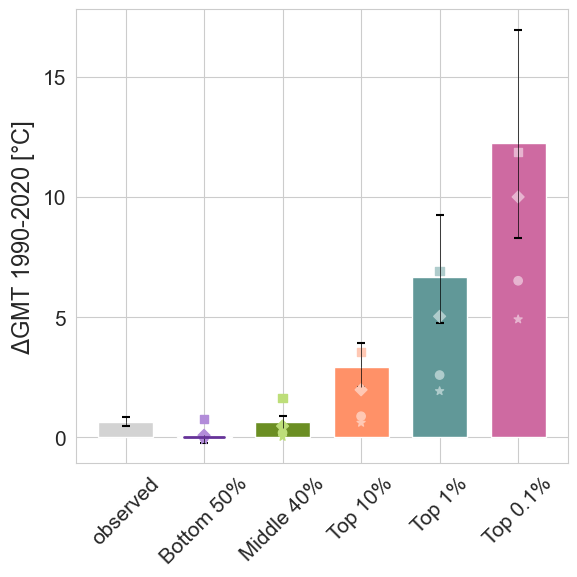

In [98]:
# top 10: orange
# top 1: purple 
# top 20: 
delta_gmt  = magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean()
delta_gmts = []
delta_gmts_low = []
delta_gmts_high = []
for group in ['p0p50', 'p50p90', 'p90p100', 'p99p100', 'p999p100']:
    delta_gmts.append(magicc_output_df[magicc_output_df.scenario == f'everyon-like_World_{group}'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean())
    delta_gmts_low.append(np.quantile(magicc_output_df[magicc_output_df.scenario == f'everyon-like_World_{group}'].loc[:, '2020-01-01 00:00:00'].values- magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean(), q = 0.05))
    delta_gmts_high.append(np.quantile(magicc_output_df[magicc_output_df.scenario == f'everyon-like_World_{group}'].loc[:, '2020-01-01 00:00:00'].values- magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean(), q = 0.95))

regional_gmt = []
for region in regions:
    gmt_tmp = []
    for group in ['p0p50', 'p50p90', 'p90p100', 'p99p100', 'p999p100']:
        gmt_tmp.append(magicc_output_df[magicc_output_df.scenario == f'everyon-like_{region}_{group}'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean())
    regional_gmt.append(gmt_tmp)
    
symbols = ["o", 's', '*', 'D']
    
import matplotlib.colors as mc
import matplotlib

cmap = matplotlib.cm.get_cmap('viridis')
# colors = ['lightgray'] + [cmap(i) for i in np.linspace(0,1,5)]
colors = ['lightgray'] + ['rebeccapurple', 'olivedrab', 'coral', lighten_color('teal', 0.95), lighten_color('mediumvioletred', 0.95)]

colors = ['lightgray'] + ['rebeccapurple', 
                           'olivedrab',
                          [1.        , 0.56862745, 0.40915033, 1.        ], 
                          [0.38065359, 0.59686275, 0.59686275, 1.        ],
                          [0.80915033, 0.41568627, 0.63137255, 1.        ]
                          ]

# colors = ['lightgray', 'C1', 'C2', 'C3', 'C5', 'C4'] 
lighter_colors = [lighten_color(color, 0.5) for color in colors]

uncertainty_color = 'black'
sensitvitiy_color = 'saddlebrown'

with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize = (6,6))
        
    bar1 = ax.bar([0,1,2,3,4,5], [delta_gmt]+delta_gmts, width = 0.7, color = colors)
    
    ax.vlines(0, delta_gmt_range[0], delta_gmt_range[1], color = uncertainty_color, lw = 0.5)
    for i in range(5): 
        ax.vlines(i+1, delta_gmts_low[i], delta_gmts_high[i], color = uncertainty_color, lw = 0.5)
    
    plt.plot([0.75,1.25], [0,0], color = 'rebeccapurple', lw = 2)
        
    ax.scatter(0, [delta_gmt_range[0]], color = uncertainty_color, marker = '_')
    ax.scatter(0, [delta_gmt_range[1]], color = uncertainty_color, marker = '_')
    
    ax.scatter(np.array([1,2,3,4,5]), delta_gmts_low[:], color = uncertainty_color, marker = '_')
    ax.scatter(np.array([1,2,3,4,5]), delta_gmts_high[:], color = uncertainty_color, marker = '_')
    
    for i_region in range(len(regions)):
        ax.scatter(np.array([1,2,3,4,5]), regional_gmt[i_region], color = lighter_colors[1:], marker = symbols[i_region], facecolors=lighter_colors[1:])

    ax.set_ylabel('$\Delta$GMT 1990-2020 [°C]', 
                  fontsize  = fontsize_large)
    ax.set_xticks([0,1,2,3,4,5], 
                  ['observed', 'Bottom 50%', 'Middle 40%', 'Top 10%', 'Top 1%', 'Top 0.1%'], 
                  rotation = 45, 
                  fontsize = fontsize_medium)
    ax.set_yticks([0,5,10,15], 
                  [0,5,10,15], 
                  fontsize = fontsize_medium)
    
    plt.tight_layout()
    # Path(GRAPHICS_DIR / "GMT").mkdir(parents=True, exist_ok=True)
    # plt.savefig(GRAPHICS_DIR / "GMT" / 'gmt_results_World_everyone-like-globbal.png', dpi = 600)
    plt.show()

### population estimates


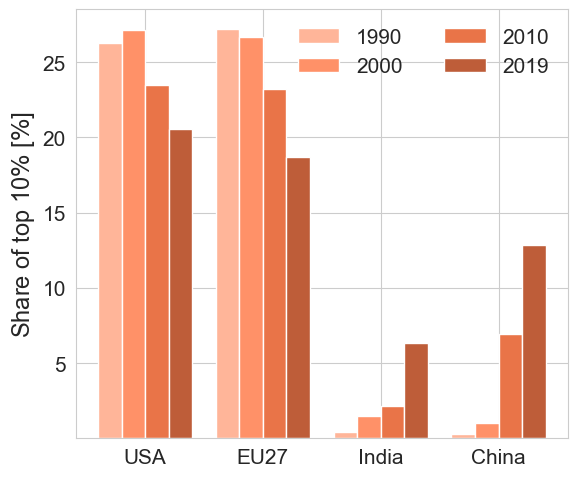

In [89]:
sel_regions = ['USA', 'NLD', 'IND', 'CHN', 'JPN', 'GBR', 'CAN', 'BRA']
bar_graph_data = pd.DataFrame(index = [1990,2000,2010,2019], columns = sel_regions)
EU27_ids = ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK']


for year in [1990,2000,2010,2019]: 
    group     = 'p90p100'
    region_id = 'WO'

    results_df = pd.read_csv(WID_DATA_PROCESSED / 'wealthy_by_location' / f'WID_data_{region_id}_{group}_{year}.csv', sep = ';', index_col = 0) 

    eu27_totals = results_df.loc[EU27_ids, :].sum(axis = 0)
    eu27_totals['fraction_of_population_in_group'] = eu27_totals['population_in_group']/eu27_totals['population_all']

    for iso in EU27_ids: 
        results_df.loc[iso, :] = eu27_totals

    isoa3 = {}
    for country in pycountry.countries:
        isoa3[country.alpha_2] = country.alpha_3

    results_df.loc[:, 'iso_a3']   = [isoa3[f] for f in results_df.index]

    results_df.loc[:, 'alpha_a2'] = results_df.index
    results_df.index = results_df.iso_a3
    
    iso_one_eu  = [f for f in results_df.alpha_a2 if f not in EU27_ids[1:]]
    for iso in sel_regions: 
        bar_graph_data.loc[year, iso] = results_df.loc[iso, 'population_in_group']/results_df.loc[results_df.alpha_a2.isin(iso_one_eu), 'population_in_group'].sum()*100

bar_graph_data.rename(columns = {'NLD': 'EU27'}, inplace = True)
bar_graph_data.to_csv(WID_DATA_PROCESSED / 'wealthy_by_location' / f'WID_{region_id}_{group}_data_bar_graph.csv', sep = ';')

# plotting on map: 
fontsize_small = 13
fontsize_medium = 15
fontsize_large = 17

colors = sns.color_palette("Oranges", as_cmap=True)(np.linspace(0.2,1,4))
# colors = sns.color_palette("colorblind")
colors = sns.color_palette("blend:#FFB599,#FF7F50,#BE5D39", as_cmap=True)(np.linspace(0,1,4))

sel_bar_graph_data = bar_graph_data.iloc[:,:4]

width = 0.2
multiplier = 0
position = np.arange(4)
with sns.axes_style('whitegrid'):
    fig, ax  = plt.subplots(figsize = (6,5))
    for i_year in range(4): 
        offset = width * multiplier
        ax.bar(position + offset, sel_bar_graph_data.iloc[i_year, :], width, color = colors[i_year], label = int(sel_bar_graph_data.index[i_year]))
        multiplier += 1
        
    ax.set_xticks(position + 1.5*width, 
                  ['USA', 'EU27', 'India', 'China'], 
                  fontsize = fontsize_medium)
    ax.set_yticks([5,10,15,20,25],
                  [5,10,15,20,25], 
                  fontsize = fontsize_medium)
    ax.set_ylabel('Share of top 10$\%$ [$\%$]', fontsize = fontsize_large)
    plt.legend(ncols = 2, frameon = False, fontsize = fontsize_medium)
    plt.tight_layout()
    # Path(GRAPHICS_DIR / "income_distribution").mkdir(parents=True, exist_ok=True)
    # plt.savefig(GRAPHICS_DIR / "income_distribution" / f"regional_bar-graph_{group}_timeseeries-shares.png", dpi = 600)
    plt.show()

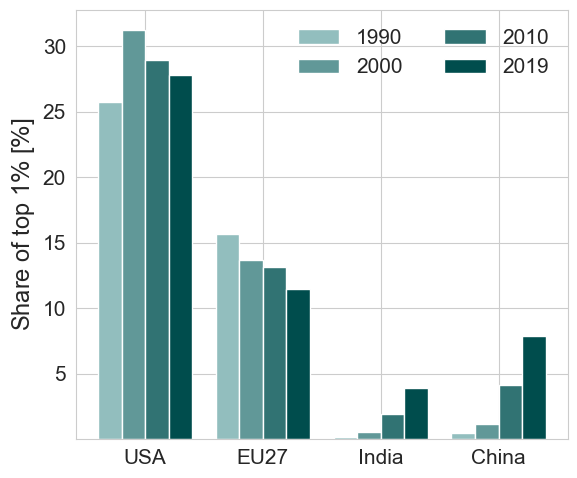

In [90]:
sel_regions = ['USA', 'NLD', 'IND', 'CHN', 'JPN', 'GBR', 'CAN', 'BRA']
bar_graph_data = pd.DataFrame(index = [1990,2000,2010,2019], columns = sel_regions)

for year in [1990,2000,2010,2019]: 
    group     = 'p99p100'
    region_id = 'WO'

    results_df = pd.read_csv(WID_DATA_PROCESSED / 'wealthy_by_location' / f'WID_data_{region_id}_{group}_{year}.csv', sep = ';', index_col = 0) 

    eu27_totals = results_df.loc[EU27_ids, :].sum(axis = 0)
    eu27_totals['fraction_of_population_in_group'] = eu27_totals['population_in_group']/eu27_totals['population_all']

    for iso in EU27_ids: 
        results_df.loc[iso, :] = eu27_totals

    isoa3 = {}
    for country in pycountry.countries:
        isoa3[country.alpha_2] = country.alpha_3

    results_df.loc[:, 'iso_a3']   = [isoa3[f] for f in results_df.index]

    results_df.loc[:, 'alpha_a2'] = results_df.index
    results_df.index = results_df.iso_a3
    
    iso_one_eu  = [f for f in results_df.alpha_a2 if f not in EU27_ids[1:]]
    for iso in sel_regions: 
        bar_graph_data.loc[year, iso] = results_df.loc[iso, 'population_in_group']/results_df.loc[results_df.alpha_a2.isin(iso_one_eu), 'population_in_group'].sum()*100

bar_graph_data.rename(columns = {'NLD': 'EU27'}, inplace = True)
bar_graph_data.to_csv(WID_DATA_PROCESSED / 'wealthy_by_location' / f'WID_{region_id}_{group}_data_bar_graph.csv', sep = ';')

# plotting on map: 
fontsize_small = 13
fontsize_medium = 15
fontsize_large = 17

colors = sns.color_palette("Oranges", as_cmap=True)(np.linspace(0.2,1,4))
# colors = sns.color_palette("colorblind")
colors = sns.color_palette("blend:#B6DADA,#004D4D", as_cmap=True)(np.linspace(0.2,1,4))

sel_bar_graph_data = bar_graph_data.iloc[:,:4]

width = 0.2
multiplier = 0
position = np.arange(4)
with sns.axes_style('whitegrid'):
    fig, ax  = plt.subplots(figsize = (6,5))
    for i_year in range(4): 
        offset = width * multiplier
        ax.bar(position + offset, sel_bar_graph_data.iloc[i_year, :], width, color = colors[i_year], label = int(sel_bar_graph_data.index[i_year]))
        multiplier += 1
        
    ax.set_xticks(position + 1.5*width, 
                  ['USA', 'EU27', 'India', 'China'], 
                  fontsize = fontsize_medium)
    ax.set_yticks([5,10,15,20,25, 30],
                  [5,10,15,20,25, 30], 
                  fontsize = fontsize_medium)
    ax.set_ylabel('Share of top 1$\%$ [$\%$]', fontsize = fontsize_large)
    plt.legend(ncols = 2, frameon = False, fontsize = fontsize_medium)
    plt.tight_layout()
    # Path(GRAPHICS_DIR / "income_distribution").mkdir(parents=True, exist_ok=True)
    # plt.savefig(GRAPHICS_DIR / "income_distribution" / f"regional_bar-graph_{group}_timeseeries-shares.png", dpi = 600)
    plt.show()

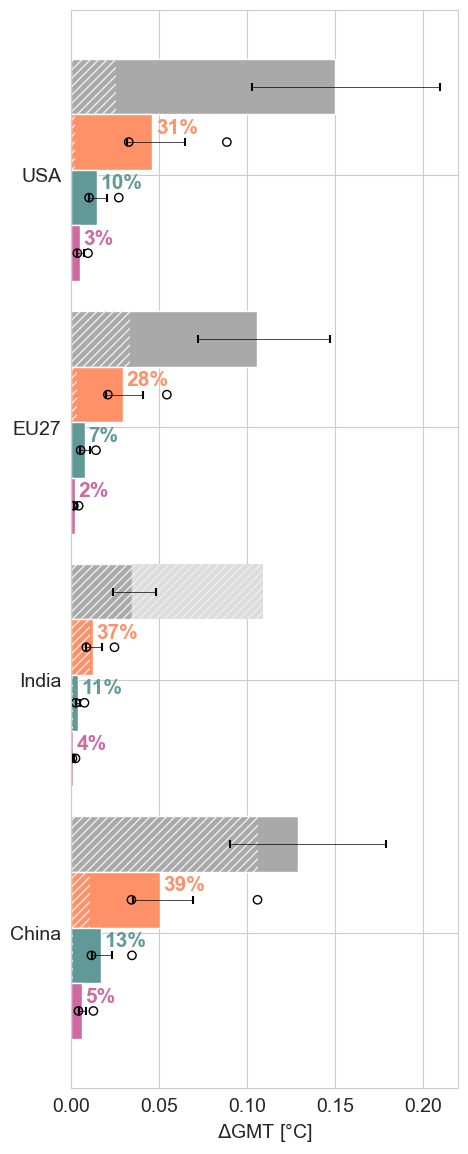

In [67]:
with sns.axes_style('whitegrid'):
    fig, axs = plt.subplots(1,1, figsize = (5, 14))  # Adjust figsize for horizontal orientation
    for i_region in range(len(regions)):
        region = regions[i_region]
        share = shares[i_region]
        delta_gmt = magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean()
        group_deltas = []
        for group in ['p0p100', 'p90p100', 'p99p100', 'p999p100']:
            group_deltas.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
        
        group_deltas_fair = [delta_gmt*i*share for i in [1, 0.1, 0.01, 0.001]]
        
        delta_gmt_range = (magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00']-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00']).quantile([0.05, 0.95]).values
        delta_gmt_range = [gmt*share for gmt in delta_gmt_range]
        
        group_deltas_low = []
        group_deltas_hi = []
        for group in ['p0p100', 'p90p100', 'p99p100', 'p999p100']:
            group_deltas_low.append(np.quantile((magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].values), q = 0.05))
            group_deltas_hi.append(np.quantile((magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].values), q = 0.95))

        group_deltas_sensitivitiy_low = []
        group_deltas_sensitivitiy_hi = []
        for group in ['p0p100', 'p90p100', 'p99p100', 'p999p100']:
            group_deltas_sensitivitiy_low.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_CO2-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
            group_deltas_sensitivitiy_hi.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()- magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_CH4-scaling'].loc[:, '2020-01-01 00:00:00'].mean())

        height = 0.22  # Adjust the height for horizontal bars
        start = 0.15
        loc_bar = np.array([start, start + height, start + height * 2, start + height * 3]) + i_region

        ax = axs
        
        bar1 = ax.barh(loc_bar, group_deltas[:], height=height, color=colors)  # Use barh for horizontal bars
        if group_deltas[0] < group_deltas_fair[0]:
            ax.barh(loc_bar[0], group_deltas_fair[0]-group_deltas[0], left=group_deltas[0], height=height, color='gainsboro', lw=0)
        ax.barh(loc_bar, group_deltas_fair[:], height=height, color='none', edgecolor=lighter_colors[:], hatch=2*'//', lw=0)

        for i in range(4): 
            if i == 0:
                ax.hlines(loc_bar[i], group_deltas_low[i], group_deltas_hi[i], color=uncertainty_color, lw=0.5)
                ax.scatter(group_deltas_low[i], loc_bar[i], color=uncertainty_color,  marker='|')
                ax.scatter(group_deltas_hi[i], loc_bar[i], color=uncertainty_color, marker='|')
            else: 
                ax.hlines(loc_bar[i], group_deltas_low[i], group_deltas_hi[i], color=uncertainty_color, lw=0.5)

        ax.scatter(group_deltas_low[1:], loc_bar[1:], color=uncertainty_color, marker='|')
        ax.scatter(group_deltas_hi[1:], loc_bar[1:], color=uncertainty_color, marker='|')

        ax.scatter(group_deltas_sensitivitiy_low[1:], loc_bar[1:], color=uncertainty_color, marker='o', facecolors='none')
        ax.scatter(group_deltas_sensitivitiy_hi[1:], loc_bar[1:], color=uncertainty_color, marker='o', facecolors='none')

        i_bar = 0 
        for rect in bar1:
            if i_bar == 0:
                i_bar += 1
                continue
            else: 
                width = rect.get_height()
                ratio = np.round(group_deltas[i_bar] / group_deltas[0] * 100, 2)
                ax.text(rect.get_x()+rect.get_width() + 0.002, rect.get_y()+rect.get_height()/2.4, f'{ratio:.0f}%', 
                        ha='left', 
                        va='bottom', 
                        color=colors[i_bar],
                        fontsize=fontsize_medium,
                        weight='bold')
                i_bar += 1

    ax.set_xlabel('$\Delta$GMT [°C]')  # Swap x-axis and y-axis labels
    ax.set_yticks([0.5, 1.5, 2.5, 3.5], [region_names[region] for region in regions], rotation=0)
    
    ax.invert_yaxis()  # Invert the y-axis to have the first region at the top
    
    plt.show()


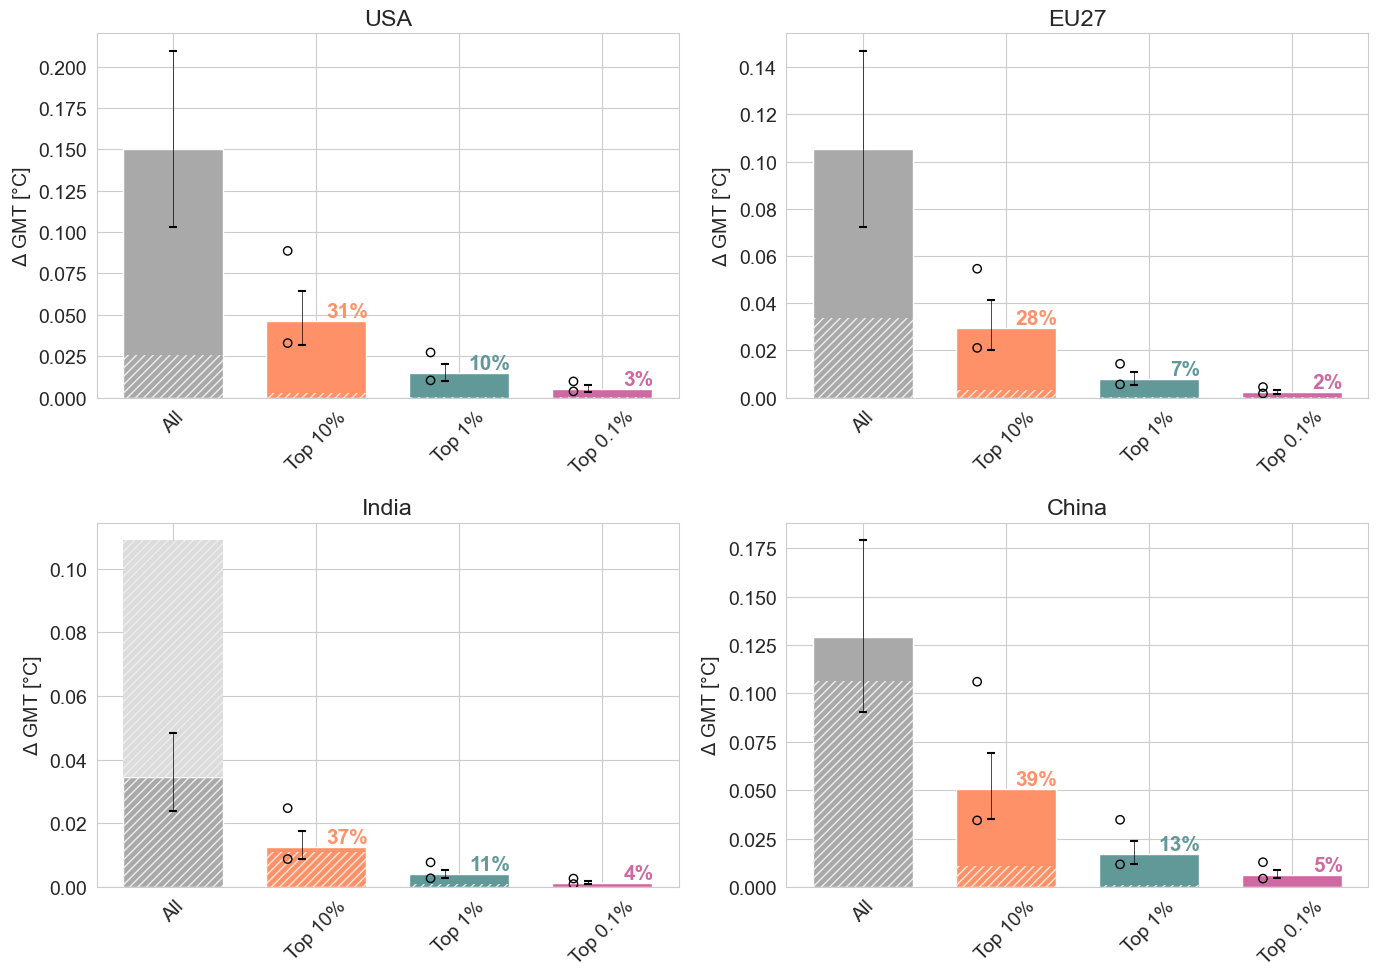

In [56]:
with sns.axes_style('whitegrid'):
    fig, axs = plt.subplots(2,2, figsize = (14,10))
    for i_region in range(len(regions)):
        region = regions[i_region]
        share = shares[i_region]
        delta_gmt = magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean()
        group_deltas = []
        for group in ['p0p100', 'p90p100', 'p99p100', 'p999p100']:
            group_deltas.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
        
        group_deltas_fair = [delta_gmt*i*share for i in [1, 0.1, 0.01, 0.001]]
        
        delta_gmt_range = (magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00']-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00']).quantile([0.05, 0.95]).values
        delta_gmt_range = [gmt*share for gmt in delta_gmt_range]
        
        group_deltas_low = []
        group_deltas_hi = []
        for group in ['p0p100', 'p90p100', 'p99p100', 'p999p100']:
            group_deltas_low.append(np.quantile((magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].values), q = 0.05))
            group_deltas_hi.append(np.quantile((magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].values), q = 0.95))

        group_deltas_sensitivitiy_low = []
        group_deltas_sensitivitiy_hi = []
        for group in ['p0p100', 'p90p100', 'p99p100', 'p999p100']:
            group_deltas_sensitivitiy_low.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_CO2-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
            group_deltas_sensitivitiy_hi.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()- magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_CH4-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
        
        i_col = i_region%2
        i_row = int((i_region-i_col)/2)
        ax = axs[i_row, i_col]
        
        bar1 = ax.bar([1,2,3,4], group_deltas[:], width = 0.7, color = colors)
        if  group_deltas[0] < group_deltas_fair[0]:
            ax.bar(1, group_deltas_fair[0]-group_deltas[0], bottom = group_deltas[0], width = 0.7, color = 'gainsboro', lw = 0)
        ax.bar([1,2,3,4], group_deltas_fair[:], width = 0.7, color = 'none', edgecolor = lighter_colors[:], hatch = 2*'//', lw = 0)
        
        for i in range(4): 
            if i == 0:
                ax.vlines(i+1, group_deltas_low[i], group_deltas_hi[i], color = uncertainty_color, lw = 0.5)
                ax.scatter(1, group_deltas_low[i], color = uncertainty_color, marker = '_')
                ax.scatter(1, group_deltas_hi[i], color = uncertainty_color, marker = '_')
            else: 
                ax.vlines(i+1-0.1, group_deltas_low[i], group_deltas_hi[i], color = uncertainty_color, lw = 0.5)
                
        ax.scatter(np.array([2,3,4])-0.1, group_deltas_low[1:], color = uncertainty_color, marker = '_')
        ax.scatter(np.array([2,3,4])-0.1, group_deltas_hi[1:], color = uncertainty_color, marker = '_')
        
        ax.scatter(np.array([1,2,3,4])-0.2, group_deltas_sensitivitiy_low[:], color = uncertainty_color, marker = 'o', facecolors='none')
        ax.scatter(np.array([1,2,3,4])-0.2, group_deltas_sensitivitiy_hi[:], color = uncertainty_color, marker = 'o', facecolors='none')
        
        i_bar = 0 
        for rect in bar1:
            if i_bar == 0:
                i_bar += 1
                continue
            else: 
                height = rect.get_height()
                ratio  = np.round(group_deltas[i_bar]/group_deltas[0]*100,2)
                ax.text(rect.get_x() + rect.get_width(), height, f'{ratio:.0f}%', 
                        ha='right', 
                        va='bottom', 
                        color = colors[i_bar],
                        fontsize = fontsize_medium,
                        weight = 'bold'
                        )
                i_bar += 1
        
        # ax.bar([1.2, 2.2, 3.2], group_deltas_fair, width = 0.4, color = ['orange', 'green', 'red'])

        ax.set_ylabel('$\Delta$ GMT [°C]')
        ax.set_xticks([1,2,3,4], ['All', f'Top 10%', f'Top 1%', f'Top 0.1%'], rotation = 45)
        ax.set_title(f'{region_names[region]}')
        
    # fig.legend(handles, ['oral', 'physa'], bbox_to_anchor=(2, 0),loc = 'lower right')
    # plt.subplots_adjust(left=0.07, right=0.93, wspace=0.25, hspace=0.35)
    plt.tight_layout()
    # plt.savefig(path_output + f'gmt_results_all-regions_processed_v1.png', dpi = 600)
    plt.show()

In [6]:
delta_gmt = magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean()
group_deltas = []
for group in ['p80p100', 'p90p100', 'p95p100', 'p99p100', 'p999p100']:
    group_deltas.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == f'World_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
    
group_deltas_fair = [delta_gmt*i for i in [0.2, 0.1, 0.05, 0.01, 0.001]]

In [7]:
delta_gmt_range = (magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00']-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00']).quantile([0.05, 0.95]).values
group_deltas_low = []
group_deltas_hi = []
for group in ['p80p100', 'p90p100', 'p95p100', 'p99p100', 'p999p100']:
    group_deltas_low.append(np.quantile((magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_output_df[magicc_output_df.scenario == f'World_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].values), q = 0.05))
    group_deltas_hi.append(np.quantile((magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_output_df[magicc_output_df.scenario == f'World_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].values), q = 0.95))
    

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_31531/1797296029.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


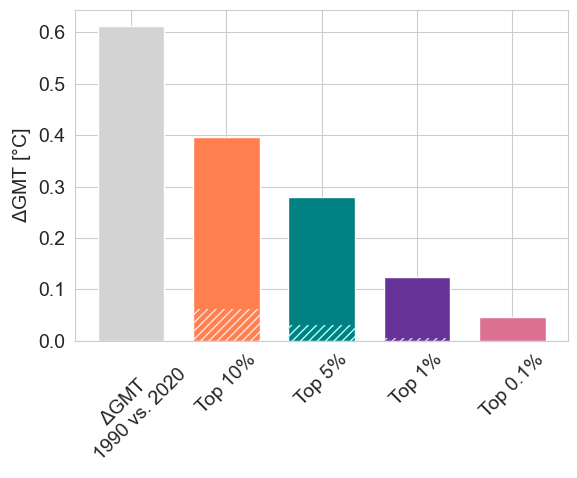

In [9]:
# top 10: orange
# top 1: purple 
# top 20: 
import matplotlib.colors as mc
import matplotlib

cmap = matplotlib.cm.get_cmap('viridis')
# colors = ['lightgray'] + [cmap(i) for i in np.linspace(0,1,5)]
colors = ['lightgray'] + ['coral', 'teal', 'rebeccapurple', 'palevioletred']
# colors = ['lightgray', 'C1', 'C2', 'C3', 'C5', 'C4'] 
lighter_colors = [lighten_color(color, 0.2) for color in colors]

with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize = (6,5))
    ax.bar([0,1,2,3,4,], [delta_gmt]+group_deltas[1:], width = 0.7, color = colors)
    ax.bar([1,2,3,4], group_deltas_fair[1:], width = 0.7, color = 'none', edgecolor = lighter_colors[1:], hatch = 2*'//', lw = 0)
    # ax.bar([1.2, 2.2, 3.2], group_deltas_fair, width = 0.4, color = ['orange', 'green', 'red'])
 
    ax.set_ylabel('$\Delta$GMT [°C]')
    ax.set_xticks([0,1,2,3,4], ['$\Delta$GMT \n 1990 vs. 2020', 'Top 10%', 'Top 5%', 'Top 1%', 'Top 0.1%'], rotation = 45)
    plt.tight_layout()
    Path(GRAPHICS_DIR / "GMT").mkdir(parents=True, exist_ok=True)
    plt.savefig(GRAPHICS_DIR / "GMT" / 'gmt_results_World_processed_v2.png', dpi = 600)
    plt.show()

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_31531/3890474153.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


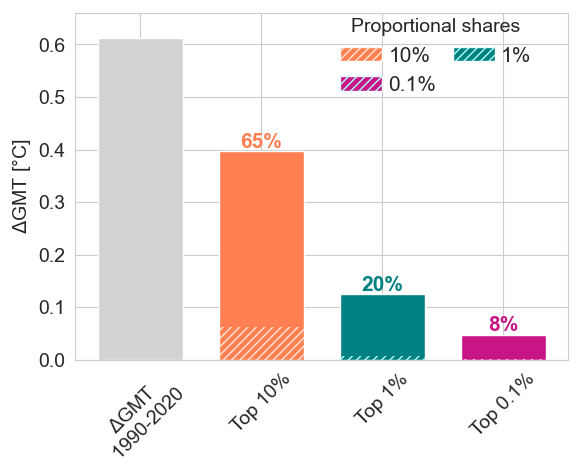

In [10]:
# top 10: orange
# top 1: purple 
# top 20: 
delta_gmt = magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean()
group_deltas = []
for group in ['p80p100', 'p90p100', 'p99p100', 'p999p100']:
    group_deltas.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == f'World_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
    
group_deltas_fair = [delta_gmt*i for i in [0.2, 0.1, 0.01, 0.001]]


import matplotlib.colors as mc
import matplotlib

cmap = matplotlib.cm.get_cmap('viridis')
# colors = ['lightgray'] + [cmap(i) for i in np.linspace(0,1,5)]
colors = ['lightgray'] + ['coral', 'teal', 'mediumvioletred', 'rebeccapurple']
# colors = ['lightgray', 'C1', 'C2', 'C3', 'C5', 'C4'] 
lighter_colors = [lighten_color(color, 0.2) for color in colors]

with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize = (6,5))
    bar1 = ax.bar([0,1,2,3,], [delta_gmt]+group_deltas[1:], width = 0.7, color = colors)
    bar2 = ax.bar([1,2,3], group_deltas_fair[1:], width = 0.7, color = 'none', edgecolor = lighter_colors[1:], hatch = 2*'//', 
                  lw = 0)
    # ax.bar([1.2, 2.2, 3.2], group_deltas_fair, width = 0.4, color = ['orange', 'green', 'red'])

    # Add counts above the two bar graphs
    i_bar = 0 
    for rect in bar1:
        if i_bar == 0:
            i_bar += 1
            continue
        else: 
            height = rect.get_height()
            ratio  = np.round(group_deltas[:][i_bar]/delta_gmt*100,2)
            ax.text(rect.get_x() + rect.get_width() / 2.0, height, f'{ratio:.0f}%', 
                    ha='center', 
                    va='bottom', 
                    color = colors[i_bar],
                    fontsize = fontsize_medium,
                    weight = 'bold'
                    )
            i_bar += 1
            
    # handels = [(bar1[1], bar2[0]), (bar1[2], bar2[1]), (bar1[3], bar2[1])]
    # labels  = ['', '', 'proportional \n share']
    # leg = ax.legend(handels, labels, frameon = False, ncols = 3, bbox_to_anchor=(0.42, 1.025), handletextpad=0.3, columnspacing=0.1)

    handels = [(bar1[1], bar2[0]), (bar1[3], bar2[1]),  (bar1[2], bar2[1])]
    labels  = ['10%', '0.1%', '1%']
    leg = ax.legend(handels, labels, frameon = False, ncols = 2, bbox_to_anchor=(0.5, 1.04), columnspacing=0.8, handletextpad=0.3, fontsize = fontsize_medium, title = 'Proportional shares')

    ax.set_ylabel('$\Delta$GMT [°C]')
    ax.set_xticks([0,1,2,3], ['$\Delta$GMT \n 1990-2020', 'Top 10%', 'Top 1%', 'Top 0.1%'], rotation = 45)
    plt.ylim(0,0.66)
    plt.tight_layout()
    Path(GRAPHICS_DIR / "GMT").mkdir(parents=True, exist_ok=True)
    plt.savefig(GRAPHICS_DIR / "GMT" / 'gmt_results_World_processed.pdf', dpi = 600)
    plt.show()

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_31531/2927622432.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


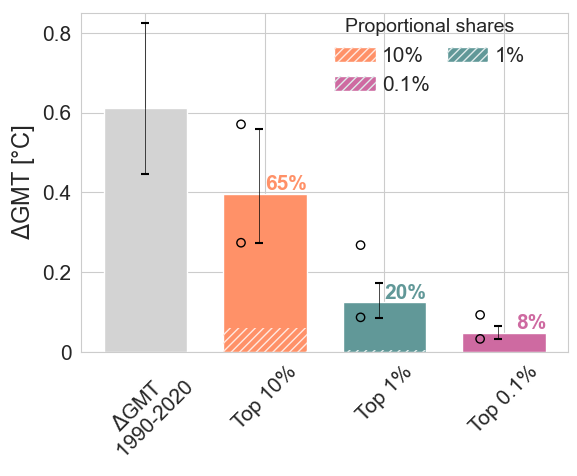

In [16]:
# top 10: orange
# top 1: purple 
# top 20: 
delta_gmt = magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean()
group_deltas = []
for group in ['p80p100', 'p90p100', 'p99p100', 'p999p100']:
    group_deltas.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == f'World_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
    
group_deltas_fair = [delta_gmt*i for i in [0.2, 0.1, 0.01, 0.001]]

delta_gmt_range = (magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00']-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00']).quantile([0.05, 0.95]).values
group_deltas_low = []
group_deltas_hi = []
for group in ['p80p100', 'p90p100', 'p99p100', 'p999p100']:
    group_deltas_low.append(np.quantile((magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_output_df[magicc_output_df.scenario == f'World_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].values), q = 0.05))
    group_deltas_hi.append(np.quantile((magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_output_df[magicc_output_df.scenario == f'World_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].values), q = 0.95))

group_deltas_sensitivitiy_low = []
group_deltas_sensitivitiy_hi = []
for group in ['p80p100', 'p90p100', 'p99p100', 'p999p100']:
    group_deltas_sensitivitiy_low.append(magicc_sensitivity_df[magicc_sensitivity_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_sensitivity_df[magicc_sensitivity_df.scenario == f'World_{group}_CO2-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
    group_deltas_sensitivitiy_hi.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()- magicc_sensitivity_df[magicc_sensitivity_df.scenario == f'World_{group}_CH4-scaling'].loc[:, '2020-01-01 00:00:00'].mean())

import matplotlib.colors as mc
import matplotlib

cmap = matplotlib.cm.get_cmap('viridis')
# colors = ['lightgray'] + [cmap(i) for i in np.linspace(0,1,5)]
colors = ['lightgray'] + ['coral', lighten_color('teal', 0.95), lighten_color('mediumvioletred', 0.95), 'rebeccapurple']

colors = ['lightgray'] + [[1.        , 0.56862745, 0.40915033, 1.        ], 
                          [0.38065359, 0.59686275, 0.59686275, 1.        ],
                          [0.80915033, 0.41568627, 0.63137255, 1.        ],
                          [0.47006536, 0.34222222, 0.61490196, 1.        ]
                          ]

# colors = ['lightgray', 'C1', 'C2', 'C3', 'C5', 'C4'] 
lighter_colors = [lighten_color(color, 0.2) for color in colors]

uncertainty_color = 'black'
sensitvitiy_color = 'saddlebrown'

with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize = (6,5))
        
    bar1 = ax.bar([0,1,2,3], [delta_gmt]+group_deltas[1:], width = 0.7, color = colors)
    bar2 = ax.bar([1,2,3], group_deltas_fair[1:], width = 0.7, color = 'none', edgecolor = lighter_colors[1:], hatch = 2*'//', 
                  lw = 0)
    
    ax.vlines(0, delta_gmt_range[0], delta_gmt_range[1], color = uncertainty_color, lw = 0.5)
    for i in range(3): 
        ax.vlines(i+1-0.05, group_deltas_low[i+1], group_deltas_hi[i+1], color = uncertainty_color, lw = 0.5)
        
        
    ax.scatter(0, [delta_gmt_range[0]], color = uncertainty_color, marker = '_')
    ax.scatter(0, [delta_gmt_range[1]], color = uncertainty_color, marker = '_')
    
    ax.scatter(np.array([1,2,3])-0.05, group_deltas_low[1:], color = uncertainty_color, marker = '_')
    ax.scatter(np.array([1,2,3])-0.05, group_deltas_hi[1:], color = uncertainty_color, marker = '_')
    
    ax.scatter(np.array([1,2,3])-0.2, group_deltas_sensitivitiy_low[1:], color = uncertainty_color, marker = 'o', facecolors='none')
    ax.scatter(np.array([1,2,3])-0.2, group_deltas_sensitivitiy_hi[1:], color = uncertainty_color, marker = 'o', facecolors='none')
    
    # ax.plot([0,0], [delta_gmt_range[0], delta_gmt_range[1]], color = 'black', lw = 2, marker = '-')
     
    # delta_gmt_range = (magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00']-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00']).quantile([0.05, 0.95]).values
    # group_deltas_low = []
    # group_deltas_hi = []
    
    # ax.bar([1.2, 2.2, 3.2], group_deltas_fair, width = 0.4, color = ['orange', 'green', 'red'])

    # Add counts above the two bar graphs
    i_bar = 0 
    for rect in bar1:
        if i_bar == 0:
            i_bar += 1
            continue
        else: 
            height = rect.get_height()
            ratio  = np.round(group_deltas[:][i_bar]/delta_gmt*100,2)
            ax.text(rect.get_x() + rect.get_width(), height, f'{ratio:.0f}%', 
                    ha='right', 
                    va='bottom', 
                    color = colors[i_bar],
                    fontsize = fontsize_medium,
                    weight = 'bold'
                    )
            i_bar += 1
            
    # handels = [(bar1[1], bar2[0]), (bar1[2], bar2[1]), (bar1[3], bar2[1])]
    # labels  = ['', '', 'proportional \n share']
    # leg = ax.legend(handels, labels, frameon = False, ncols = 3, bbox_to_anchor=(0.42, 1.025), handletextpad=0.3, columnspacing=0.1)

    handels = [(bar1[1], bar2[0]), (bar1[3], bar2[1]),  (bar1[2], bar2[1])]
    labels  = ['10%', '0.1%', '1%']
    leg = ax.legend(handels, labels, frameon = False, ncols = 2, bbox_to_anchor=(0.95, 1.04), columnspacing=0.8, handletextpad=0.3, fontsize = fontsize_medium, title = 'Proportional shares')

    ax.set_ylabel('$\Delta$GMT [°C]', 
                  fontsize = fontsize_large)
    ax.set_yticks([0, 0.2,0.4, 0.6, 0.8],
                  [0, 0.2, 0.4, 0.6, 0.8],
                  fontsize = fontsize_medium)
    ax.set_xticks([0,1,2,3], ['$\Delta$GMT \n 1990-2020', 'Top 10%', 'Top 1%', 'Top 0.1%'], 
                  rotation = 45,
                  fontsize = fontsize_medium
                  )
    plt.ylim(0,0.85)
    plt.tight_layout()
    Path(GRAPHICS_DIR / "GMT").mkdir(parents=True, exist_ok=True)
    plt.savefig(GRAPHICS_DIR / "GMT" / 'gmt_results_World_processed_uncertainty.png', dpi = 600)
    plt.show()


In [12]:
sel_columns      = ['climate_model', 'model', 'region', 'run_id', 'scenario', 'unit', 'variable'] + [f'{int(iter)}-01-01 00:00:00' for iter in np.arange(1800, 2021,1)]


magicc_inverse_df = pd.read_csv(MAGICC_OUTPUT_FILES[3])
# pd.read_csv(MAGICC_OUTPUT_FILE)
magicc_inverse_df = magicc_inverse_df[magicc_inverse_df.variable == 'Surface Air Temperature Change'].loc[:, sel_columns]

#re-center to 1850-1900
# Select the columns corresponding to the reference period 1850-1900
reference_period = pd.date_range(start='1850-01-01', end='1900-01-01', freq='YS')
reference_cols   = [col for col in magicc_inverse_df.columns if col in reference_period.strftime('%Y-%m-%d %H:%M:%S')]

# Function to recenter data based on the reference period
def recenter_row(row):
    reference_mean = row[reference_cols].mean()
    return row[7:] - reference_mean  # Assuming the first 7 columns are non-numeric metadata

# Apply the function to recenter each row
numeric_cols = magicc_output_df.columns[7:]  # Assuming numeric data starts from the 8th column
magicc_inverse_df[numeric_cols] = magicc_inverse_df.apply(recenter_row, axis=1)
magicc_inverse_df[numeric_cols] *= 0.85*1/(magicc_inverse_df[magicc_inverse_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00':'2014-01-01 00:00:00'].mean().mean())
# *0.85

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_31531/2431805857.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


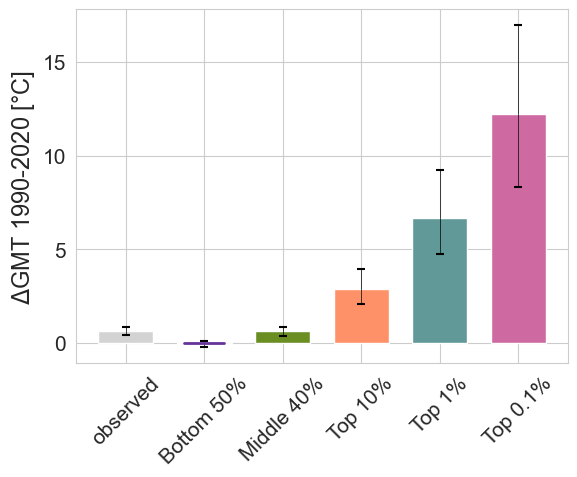

In [28]:
# top 10: orange
# top 1: purple 
# top 20: 
delta_gmt  = magicc_inverse_df[magicc_inverse_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_inverse_df[magicc_inverse_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean()
delta_gmts = []
delta_gmts_low = []
delta_gmts_high = []
for group in ['p0p50', 'p50p90', 'p90p100', 'p99p100', 'p999p100']:
    delta_gmts.append(magicc_inverse_df[magicc_inverse_df.scenario == f'everyon-like_World_{group}'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_inverse_df[magicc_inverse_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean())
    delta_gmts_low.append(np.quantile(magicc_inverse_df[magicc_inverse_df.scenario == f'everyon-like_World_{group}'].loc[:, '2020-01-01 00:00:00'].values- magicc_inverse_df[magicc_inverse_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean(), q = 0.05))
    delta_gmts_high.append(np.quantile(magicc_inverse_df[magicc_inverse_df.scenario == f'everyon-like_World_{group}'].loc[:, '2020-01-01 00:00:00'].values- magicc_inverse_df[magicc_inverse_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean(), q = 0.95))


import matplotlib.colors as mc
import matplotlib

cmap = matplotlib.cm.get_cmap('viridis')
# colors = ['lightgray'] + [cmap(i) for i in np.linspace(0,1,5)]
colors = ['lightgray'] + ['rebeccapurple', 'olivedrab', 'coral', lighten_color('teal', 0.95), lighten_color('mediumvioletred', 0.95)]

colors = ['lightgray'] + ['rebeccapurple', 
                           'olivedrab',
                          [1.        , 0.56862745, 0.40915033, 1.        ], 
                          [0.38065359, 0.59686275, 0.59686275, 1.        ],
                          [0.80915033, 0.41568627, 0.63137255, 1.        ]
                          ]

# colors = ['lightgray', 'C1', 'C2', 'C3', 'C5', 'C4'] 
lighter_colors = [lighten_color(color, 0.2) for color in colors]

uncertainty_color = 'black'
sensitvitiy_color = 'saddlebrown'

with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize = (6,5))
        
    bar1 = ax.bar([0,1,2,3,4,5], [delta_gmt]+delta_gmts, width = 0.7, color = colors)
    
    ax.vlines(0, delta_gmt_range[0], delta_gmt_range[1], color = uncertainty_color, lw = 0.5)
    for i in range(5): 
        ax.vlines(i+1, delta_gmts_low[i], delta_gmts_high[i], color = uncertainty_color, lw = 0.5)
    
    plt.plot([0.75,1.25], [0,0], color = 'rebeccapurple', lw = 2)
        
    ax.scatter(0, [delta_gmt_range[0]], color = uncertainty_color, marker = '_')
    ax.scatter(0, [delta_gmt_range[1]], color = uncertainty_color, marker = '_')
    
    ax.scatter(np.array([1,2,3,4,5]), delta_gmts_low[:], color = uncertainty_color, marker = '_')
    ax.scatter(np.array([1,2,3,4,5]), delta_gmts_high[:], color = uncertainty_color, marker = '_')

    ax.set_ylabel('$\Delta$GMT 1990-2020 [°C]', 
                  fontsize  = fontsize_large)
    ax.set_xticks([0,1,2,3,4,5], 
                  ['observed', 'Bottom 50%', 'Middle 40%', 'Top 10%', 'Top 1%', 'Top 0.1%'], 
                  rotation = 45, 
                  fontsize = fontsize_medium)
    ax.set_yticks([0,5,10,15], 
                  [0,5,10,15], 
                  fontsize = fontsize_medium)
    
    plt.tight_layout()
    Path(GRAPHICS_DIR / "GMT").mkdir(parents=True, exist_ok=True)
    plt.savefig(GRAPHICS_DIR / "GMT" / 'gmt_results_World_everyone-like-globbal.png', dpi = 600)
    plt.show()


In [29]:
delta_gmts

[-0.04180526574596666,
 0.6186916531794596,
 2.9030007544529814,
 6.679376424454409,
 12.229209214845916]

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_31531/1992386501.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


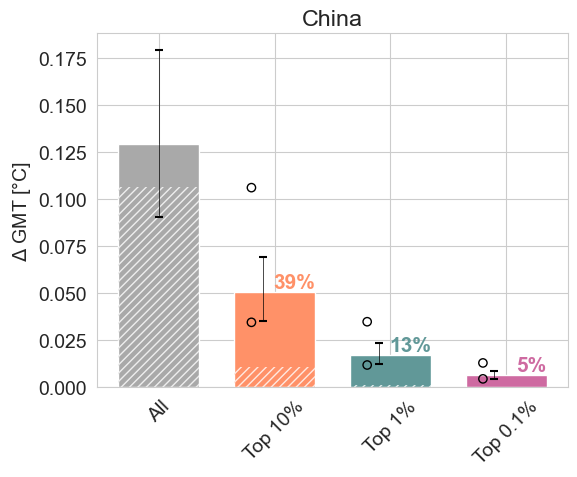

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_31531/1992386501.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


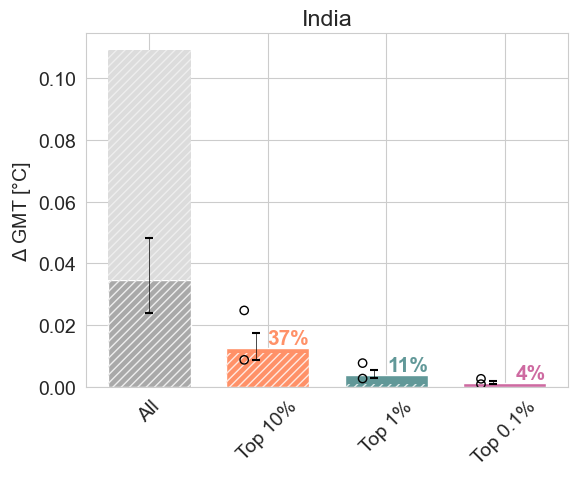

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_31531/1992386501.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


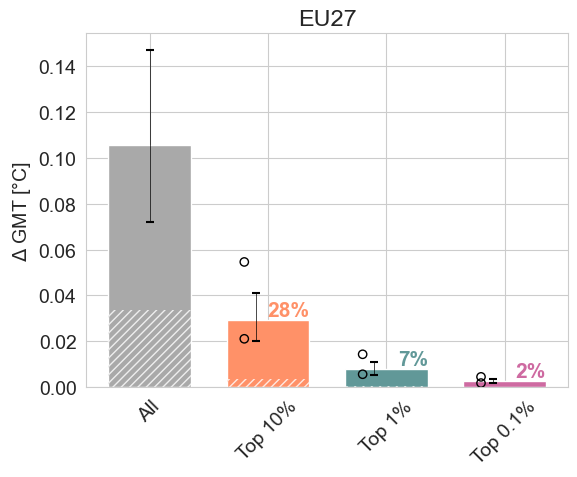

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_31531/1992386501.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


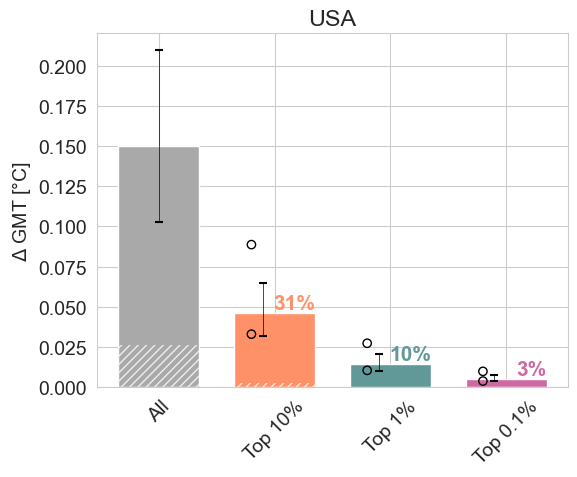

In [38]:
regions = ['CN', 'IN', 'EU27', 'US']
region_names = {'CN': 'China', 
                'IN': 'India',
                'EU27': 'EU27',
                'US': 'USA'}

shares = [0.174, 0.178,  0.055, 0.0423]


for i_region in range(len(regions)):
    region = regions[i_region]
    share = shares[i_region]
    delta_gmt = magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean()
    group_deltas = []
    for group in ['p0p100', 'p90p100', 'p99p100', 'p999p100']:
        group_deltas.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
    
    group_deltas_fair = [delta_gmt*i*share for i in [1, 0.1, 0.01, 0.001]]
    
    delta_gmt_range = (magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00']-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00']).quantile([0.05, 0.95]).values
    delta_gmt_range = [gmt*share for gmt in delta_gmt_range]
    
    group_deltas_low = []
    group_deltas_hi = []
    for group in ['p0p100', 'p90p100', 'p99p100', 'p999p100']:
        group_deltas_low.append(np.quantile((magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].values), q = 0.05))
        group_deltas_hi.append(np.quantile((magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].values), q = 0.95))

    group_deltas_sensitivitiy_low = []
    group_deltas_sensitivitiy_hi = []
    for group in ['p0p100', 'p90p100', 'p99p100', 'p999p100']:
        group_deltas_sensitivitiy_low.append(magicc_sensitivity_df[magicc_sensitivity_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_sensitivity_df[magicc_sensitivity_df.scenario == f'{region}_{group}_CO2-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
        group_deltas_sensitivitiy_hi.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()- magicc_sensitivity_df[magicc_sensitivity_df.scenario == f'{region}_{group}_CH4-scaling'].loc[:, '2020-01-01 00:00:00'].mean())


    def lighten_color(color, amount=0.5):
        """
        Lightens the given color by multiplying (1-luminosity) by the given amount.
        Input can be matplotlib color string, hex string, or RGB tuple.

        Examples:
        >> lighten_color('g', 0.3)
        >> lighten_color('#F034A3', 0.6)
        >> lighten_color((.3,.55,.1), 0.5)
        """
        import matplotlib.colors as mc
        import colorsys
        try:
            c = mc.cnames[color]
        except:
            c = color
        c = colorsys.rgb_to_hls(*mc.to_rgb(c))
        return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


    # top 10: orange
    # top 1: purple 
    # top 20: 
    import matplotlib.colors as mc
    import matplotlib

    cmap = matplotlib.cm.get_cmap('viridis')
    # colors = ['lightgray'] + [cmap(i) for i in np.linspace(0,1,5)]
    colors = ['darkgray', 
              [1.        , 0.56862745, 0.40915033, 1.        ], 
              [0.38065359, 0.59686275, 0.59686275, 1.        ],
              [0.80915033, 0.41568627, 0.63137255, 1.        ]]
    # colors = ['lightgray', 'C1', 'C2', 'C3', 'C5', 'C4'] 
    lighter_colors = [lighten_color(color, 0.2) for color in colors]
    # lighter_colors[0] = lighten_color('lightgray', 2)
    
    
    with sns.axes_style('whitegrid'):
        fig, ax = plt.subplots(figsize = (6,5))
        bar1 = ax.bar([1,2,3,4], group_deltas[:], width = 0.7, color = colors)
        if  group_deltas[0] < group_deltas_fair[0]:
            ax.bar(1, group_deltas_fair[0]-group_deltas[0], bottom = group_deltas[0], width = 0.7, color = 'gainsboro', lw = 0)
        ax.bar([1,2,3,4], group_deltas_fair[:], width = 0.7, color = 'none', edgecolor = lighter_colors[:], hatch = 2*'//', lw = 0)
        
        for i in range(4): 
            if i == 0:
                ax.vlines(i+1, group_deltas_low[i], group_deltas_hi[i], color = uncertainty_color, lw = 0.5)
                ax.scatter(1, group_deltas_low[i], color = uncertainty_color, marker = '_')
                ax.scatter(1, group_deltas_hi[i], color = uncertainty_color, marker = '_')
            else: 
                ax.vlines(i+1-0.1, group_deltas_low[i], group_deltas_hi[i], color = uncertainty_color, lw = 0.5)
                
        ax.scatter(np.array([2,3,4])-0.1, group_deltas_low[1:], color = uncertainty_color, marker = '_')
        ax.scatter(np.array([2,3,4])-0.1, group_deltas_hi[1:], color = uncertainty_color, marker = '_')
        
        ax.scatter(np.array([1,2,3,4])-0.2, group_deltas_sensitivitiy_low[:], color = uncertainty_color, marker = 'o', facecolors='none')
        ax.scatter(np.array([1,2,3,4])-0.2, group_deltas_sensitivitiy_hi[:], color = uncertainty_color, marker = 'o', facecolors='none')
        
        i_bar = 0 
        for rect in bar1:
            if i_bar == 0:
                i_bar += 1
                continue
            else: 
                height = rect.get_height()
                ratio  = np.round(group_deltas[i_bar]/group_deltas[0]*100,2)
                ax.text(rect.get_x() + rect.get_width(), height, f'{ratio:.0f}%', 
                        ha='right', 
                        va='bottom', 
                        color = colors[i_bar],
                        fontsize = fontsize_medium,
                        weight = 'bold'
                        )
                i_bar += 1
        
        # ax.bar([1.2, 2.2, 3.2], group_deltas_fair, width = 0.4, color = ['orange', 'green', 'red'])
    
        ax.set_ylabel('$\Delta$ GMT [°C]')
        ax.set_xticks([1,2,3,4], ['All', f'Top 10%', f'Top 1%', f'Top 0.1%'], rotation = 45)
        plt.title(f'{region_names[region]}')
        plt.tight_layout()
        plt.savefig(path_output + f'gmt_results_{region}_processed_v1.png', dpi = 600)
        plt.show()

In [42]:
path_output

'/Users/schoens/Documents/PhD/IIASA/06_Graphics/Presentation/'

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_31531/1082348338.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')
/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_31531/1082348338.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')
/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_31531/1082348338.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matpl

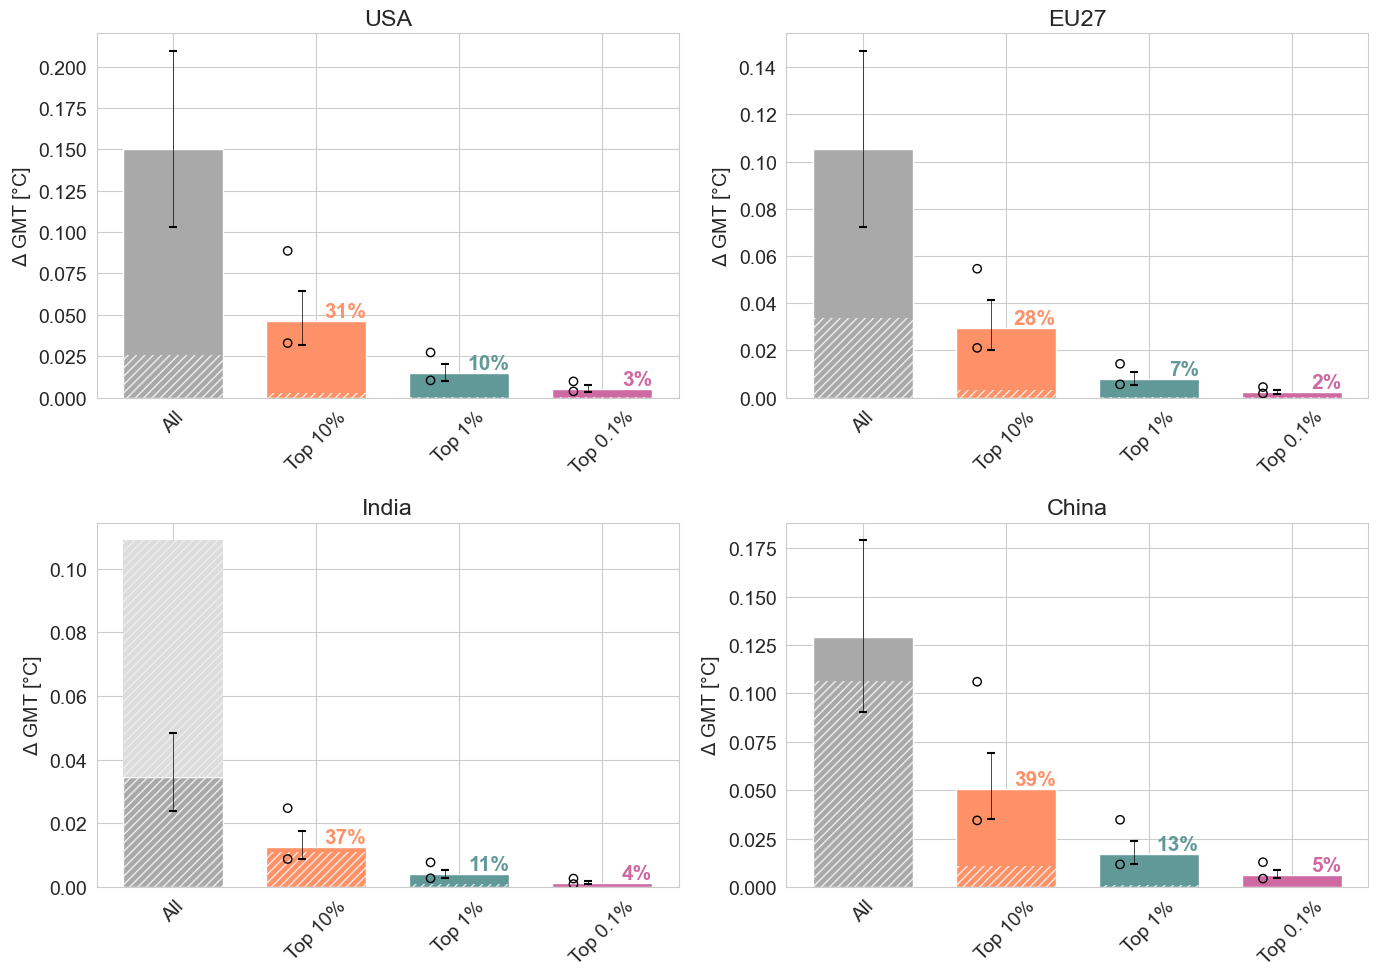

In [41]:
# regions = ['CN', 'IN', 'EU27', 'US']
regions = ['US', 'EU27', 'IN', 'CN']
region_names = {'CN': 'China', 
                'IN': 'India',
                'EU27': 'EU27',
                'US': 'USA'}

shares = [0.0423, 0.055, 0.178, 0.174]

with sns.axes_style('whitegrid'):
    fig, axs = plt.subplots(2,2, figsize = (14,10))
    for i_region in range(len(regions)):
        region = regions[i_region]
        share = shares[i_region]
        delta_gmt = magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean()
        group_deltas = []
        for group in ['p0p100', 'p90p100', 'p99p100', 'p999p100']:
            group_deltas.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
        
        group_deltas_fair = [delta_gmt*i*share for i in [1, 0.1, 0.01, 0.001]]
        
        delta_gmt_range = (magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00']-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00']).quantile([0.05, 0.95]).values
        delta_gmt_range = [gmt*share for gmt in delta_gmt_range]
        
        group_deltas_low = []
        group_deltas_hi = []
        for group in ['p0p100', 'p90p100', 'p99p100', 'p999p100']:
            group_deltas_low.append(np.quantile((magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].values), q = 0.05))
            group_deltas_hi.append(np.quantile((magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].values), q = 0.95))

        group_deltas_sensitivitiy_low = []
        group_deltas_sensitivitiy_hi = []
        for group in ['p0p100', 'p90p100', 'p99p100', 'p999p100']:
            group_deltas_sensitivitiy_low.append(magicc_sensitivity_df[magicc_sensitivity_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_sensitivity_df[magicc_sensitivity_df.scenario == f'{region}_{group}_CO2-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
            group_deltas_sensitivitiy_hi.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()- magicc_sensitivity_df[magicc_sensitivity_df.scenario == f'{region}_{group}_CH4-scaling'].loc[:, '2020-01-01 00:00:00'].mean())


        def lighten_color(color, amount=0.5):
            """
            Lightens the given color by multiplying (1-luminosity) by the given amount.
            Input can be matplotlib color string, hex string, or RGB tuple.

            Examples:
            >> lighten_color('g', 0.3)
            >> lighten_color('#F034A3', 0.6)
            >> lighten_color((.3,.55,.1), 0.5)
            """
            import matplotlib.colors as mc
            import colorsys
            try:
                c = mc.cnames[color]
            except:
                c = color
            c = colorsys.rgb_to_hls(*mc.to_rgb(c))
            return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


        # top 10: orange
        # top 1: purple 
        # top 20: 
        import matplotlib.colors as mc
        import matplotlib

        cmap = matplotlib.cm.get_cmap('viridis')
        # colors = ['lightgray'] + [cmap(i) for i in np.linspace(0,1,5)]
        colors = ['darkgray', 
                [1.        , 0.56862745, 0.40915033, 1.        ], 
                [0.38065359, 0.59686275, 0.59686275, 1.        ],
                [0.80915033, 0.41568627, 0.63137255, 1.        ]]
        # colors = ['lightgray', 'C1', 'C2', 'C3', 'C5', 'C4'] 
        lighter_colors = [lighten_color(color, 0.2) for color in colors]
        # lighter_colors[0] = lighten_color('lightgray', 2)
        
        i_col = i_region%2
        i_row = int((i_region-i_col)/2)
        ax = axs[i_row, i_col]
        
        bar1 = ax.bar([1,2,3,4], group_deltas[:], width = 0.7, color = colors)
        if  group_deltas[0] < group_deltas_fair[0]:
            ax.bar(1, group_deltas_fair[0]-group_deltas[0], bottom = group_deltas[0], width = 0.7, color = 'gainsboro', lw = 0)
        ax.bar([1,2,3,4], group_deltas_fair[:], width = 0.7, color = 'none', edgecolor = lighter_colors[:], hatch = 2*'//', lw = 0)
        
        for i in range(4): 
            if i == 0:
                ax.vlines(i+1, group_deltas_low[i], group_deltas_hi[i], color = uncertainty_color, lw = 0.5)
                ax.scatter(1, group_deltas_low[i], color = uncertainty_color, marker = '_')
                ax.scatter(1, group_deltas_hi[i], color = uncertainty_color, marker = '_')
            else: 
                ax.vlines(i+1-0.1, group_deltas_low[i], group_deltas_hi[i], color = uncertainty_color, lw = 0.5)
                
        ax.scatter(np.array([2,3,4])-0.1, group_deltas_low[1:], color = uncertainty_color, marker = '_')
        ax.scatter(np.array([2,3,4])-0.1, group_deltas_hi[1:], color = uncertainty_color, marker = '_')
        
        ax.scatter(np.array([1,2,3,4])-0.2, group_deltas_sensitivitiy_low[:], color = uncertainty_color, marker = 'o', facecolors='none')
        ax.scatter(np.array([1,2,3,4])-0.2, group_deltas_sensitivitiy_hi[:], color = uncertainty_color, marker = 'o', facecolors='none')
        
        i_bar = 0 
        for rect in bar1:
            if i_bar == 0:
                i_bar += 1
                continue
            else: 
                height = rect.get_height()
                ratio  = np.round(group_deltas[i_bar]/group_deltas[0]*100,2)
                ax.text(rect.get_x() + rect.get_width(), height, f'{ratio:.0f}%', 
                        ha='right', 
                        va='bottom', 
                        color = colors[i_bar],
                        fontsize = fontsize_medium,
                        weight = 'bold'
                        )
                i_bar += 1
        
        # ax.bar([1.2, 2.2, 3.2], group_deltas_fair, width = 0.4, color = ['orange', 'green', 'red'])

        ax.set_ylabel('$\Delta$ GMT [°C]')
        ax.set_xticks([1,2,3,4], ['All', f'Top 10%', f'Top 1%', f'Top 0.1%'], rotation = 45)
        ax.set_title(f'{region_names[region]}')
        
    # fig.legend(handles, ['oral', 'physa'], bbox_to_anchor=(2, 0),loc = 'lower right')
    # plt.subplots_adjust(left=0.07, right=0.93, wspace=0.25, hspace=0.35)
    plt.tight_layout()
    plt.savefig(path_output + f'gmt_results_all-regions_processed_v1.png', dpi = 600)
    plt.show()

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_65010/4273207391.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


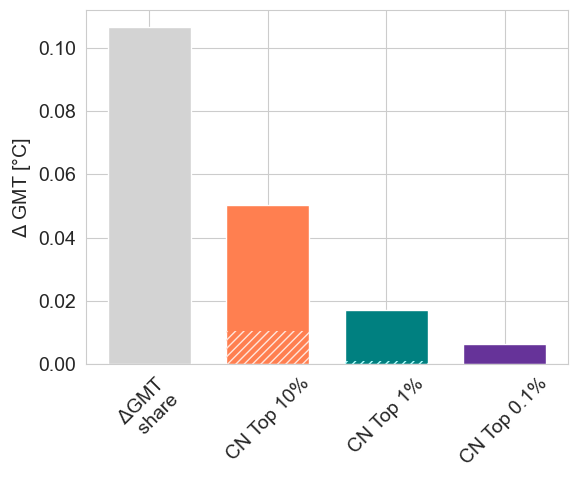

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_65010/4273207391.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


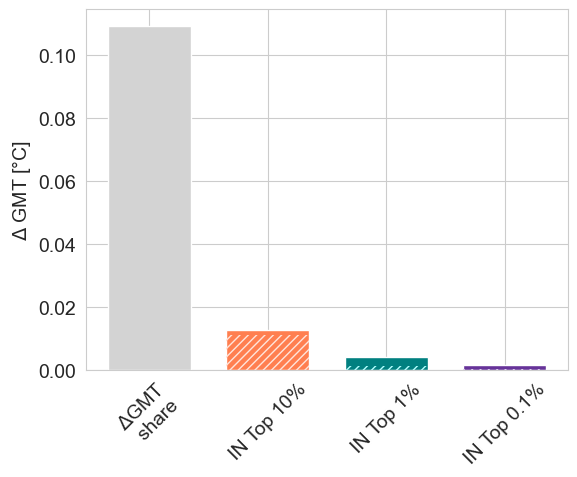

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_65010/4273207391.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


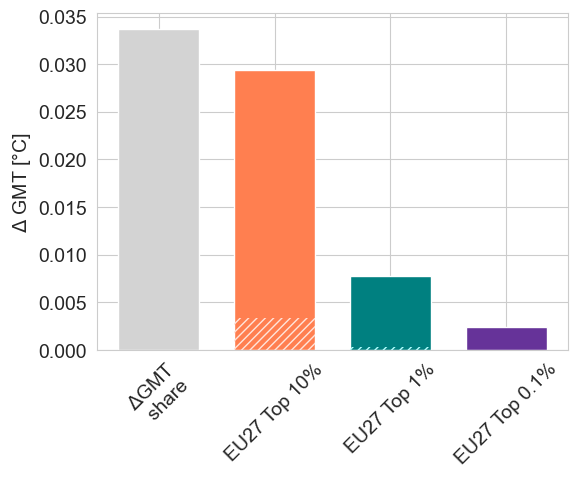

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_65010/4273207391.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


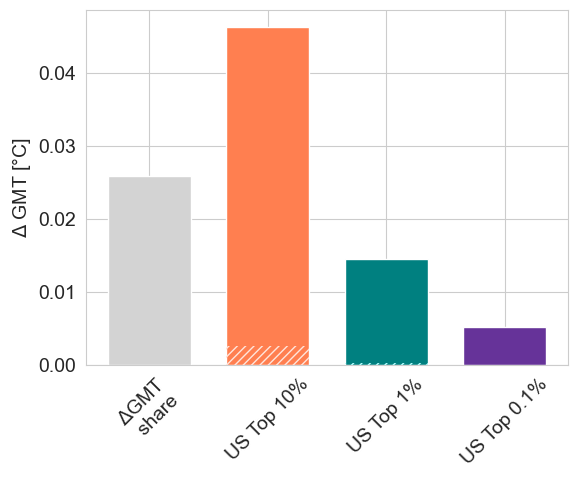

In [29]:
regions = ['CN', 'IN', 'EU27', 'US']

shares = [0.174, 0.178,  0.055, 0.0423]


for i_region in range(len(regions)):
    region = regions[i_region]
    share = shares[i_region]
    delta_gmt = magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()-magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean()
    group_deltas = []
    for group in ['p80p100', 'p90p100', 'p99p100', 'p999p100']:
        group_deltas.append(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == f'{region}_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].mean())
        
    group_deltas_fair = [delta_gmt*i*share for i in [0.2, 0.1, 0.01, 0.001]]

    def lighten_color(color, amount=0.5):
        """
        Lightens the given color by multiplying (1-luminosity) by the given amount.
        Input can be matplotlib color string, hex string, or RGB tuple.

        Examples:
        >> lighten_color('g', 0.3)
        >> lighten_color('#F034A3', 0.6)
        >> lighten_color((.3,.55,.1), 0.5)
        """
        import matplotlib.colors as mc
        import colorsys
        try:
            c = mc.cnames[color]
        except:
            c = color
        c = colorsys.rgb_to_hls(*mc.to_rgb(c))
        return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


    # top 10: orange
    # top 1: purple 
    # top 20: 
    import matplotlib.colors as mc
    import matplotlib

    cmap = matplotlib.cm.get_cmap('viridis')
    # colors = ['lightgray'] + [cmap(i) for i in np.linspace(0,1,5)]
    colors = ['lightgray'] + ['coral', 'teal', 'rebeccapurple']
    # colors = ['lightgray', 'C1', 'C2', 'C3', 'C5', 'C4'] 
    lighter_colors = [lighten_color(color, 0.2) for color in colors]

    with sns.axes_style('whitegrid'):
        fig, ax = plt.subplots(figsize = (6,5))
        ax.bar([0,1,2,3], [delta_gmt*share]+group_deltas[1:], width = 0.7, color = colors)
        ax.bar([1,2,3], group_deltas_fair[1:], width = 0.7, color = 'none', edgecolor = lighter_colors[1:], hatch = 2*'//', lw = 0)
        # ax.bar([1.2, 2.2, 3.2], group_deltas_fair, width = 0.4, color = ['orange', 'green', 'red'])
    
        ax.set_ylabel('$\Delta$ GMT [°C]')
        ax.set_xticks([0,1,2,3], ['$\Delta$GMT \n share', f'{region} Top 10%', f'{region} Top 1%', f'{region} Top 0.1%'], rotation = 45)
        plt.tight_layout()
        plt.savefig(path_output + f'gmt_results_{region}_processed_v1.png', dpi = 600)
        plt.show()

In [23]:
group_deltas[1:]/delta_gmt*100

array([64.7356537 , 45.64461562, 20.26005278,  7.65102637])

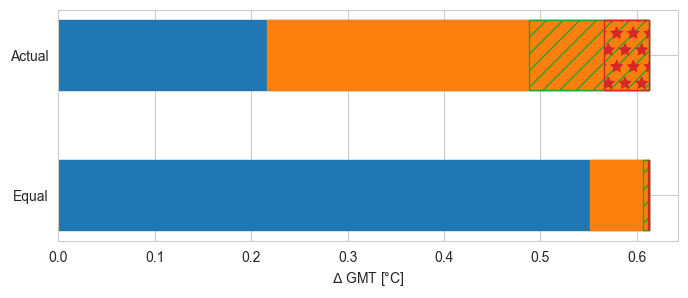

In [5]:
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize = (8,3))
    p = ax.barh(y = 0.2, 
            width = delta_gmt,
            left = 0, 
            height = 0.1, color = 'C0', edgecolor = 'C0')
    # ax.bar_label(p, label_type='edge')
    
    for i in range(len(group_deltas)): 
        if i == 0:
            ax.barh(y = 0.2, 
                    width = group_deltas[i], 
                    left = delta_gmt-group_deltas[i], height = 0.1, color = f'C{i+1}', edgecolor = f'C{i+1}')
        else: 
            ax.barh(y = 0.2, 
                    width = group_deltas[i], 
                    left = delta_gmt-group_deltas[i], height = 0.1, color = f'C{i+1}', hatch = ['', '//', '*'][i], edgecolor = f'C{i+1}', facecolor = 'None')    
    ax.barh(y = 0, 
            width = delta_gmt,
            left = 0, 
            height = 0.1, color = 'C0', edgecolor = 'C0')
    for i in range(len(group_deltas)): 
        if i == 0:
            ax.barh(y = 0, 
                    width = group_deltas_fair[i], 
                    left = delta_gmt-group_deltas_fair[i], height = 0.1, color = f'C{i+1}', edgecolor = f'C{i+1}')
        else: 
            ax.barh(y = 0, 
                    width = group_deltas_fair[i], 
                    left = delta_gmt-group_deltas_fair[i], height = 0.1, color = f'C{i+1}', hatch = ['', '//', '*'][i], edgecolor = f'C{i+1}', facecolor = 'None')    
    ax.set_xlabel('$\Delta$ GMT [°C]')
    ax.set_yticks([0, 0.2], ['Equal', 'Actual'])
    plt.show()

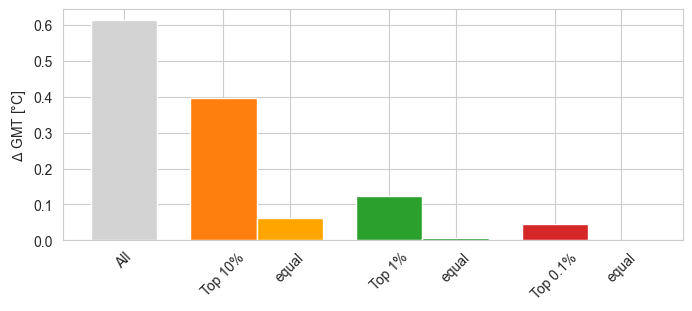

In [6]:
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize = (8,3))
    ax.bar([0.2, 0.8, 1.8, 2.8], [delta_gmt]+group_deltas, width = 0.4, color = ['lightgrey', 'C1', 'C2', 'C3'])
    ax.bar([1.2, 2.2, 3.2], group_deltas_fair, width = 0.4, color = ['orange', 'green', 'red'])
 
    ax.set_ylabel('$\Delta$ GMT [°C]')
    ax.set_xticks([0.2, 0.8, 1.2, 1.8, 2.2, 2.8, 3.2], ['All', 'Top 10%', 'equal', 'Top 1%', 'equal', 'Top 0.1%', 'equal'], rotation = 45)
    plt.show()

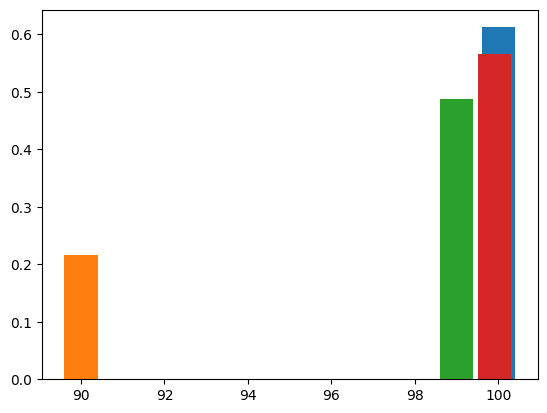

In [7]:
percentiles     = np.arange(0,100,0.1)
gmt_percentiles = [delta_gmt/1000]*1000
gmt_cumulative  = np.cumsum(gmt_percentiles)
group_deltas = []
for group in ['p90p100', 'p99p100', 'p999p100']:
    group_deltas.append(delta_gmt-(magicc_output_df[magicc_output_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_output_df[magicc_output_df.scenario == f'World_{group}_equal-scaling'].loc[:, '2020-01-01 00:00:00'].mean()))
    
plt.figure()
plt.bar([100, 90, 99, 99.9], 
        [delta_gmt] + group_deltas, color = ['C0', 'C1', 'C2', 'C3'])
# plt.plot(percentiles, gmt_cumulative)
plt.show()

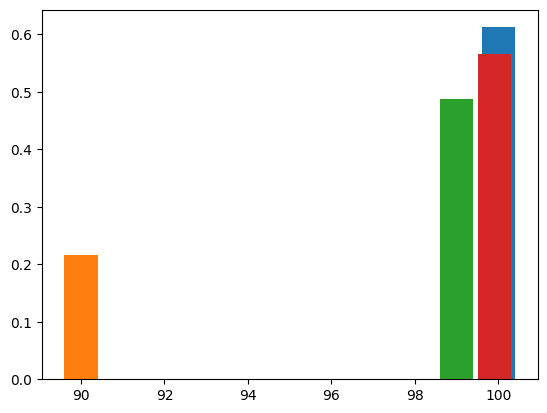

In [8]:
plt.figure()
plt.bar([100, 90, 99, 99.9], 
        [delta_gmt] + group_deltas, color = ['C0', 'C1', 'C2', 'C3'])
plt.show()

In [50]:
magicc_output_df.scenario.unique()

array(['CN_p90p100_equal-scaling', 'CN_p999p100_equal-scaling',
       'CN_p99p100_equal-scaling', 'EU27_p90p100_equal-scaling',
       'EU27_p999p100_equal-scaling', 'EU27_p99p100_equal-scaling',
       'IN_p90p100_equal-scaling', 'IN_p999p100_equal-scaling',
       'IN_p99p100_equal-scaling', 'US_p90p100_equal-scaling',
       'US_p999p100_equal-scaling', 'US_p99p100_equal-scaling',
       'World_p90p100_equal-scaling', 'World_p999p100_equal-scaling',
       'World_p99p100_equal-scaling', 'ssp245'], dtype=object)

In [45]:
percentiles     = np.arange(0,100,0.1)
gmt_percentiles = [delta_gmt/1000]*1000
gmt_cumulative  = np.cumsum(gmt_percentiles)

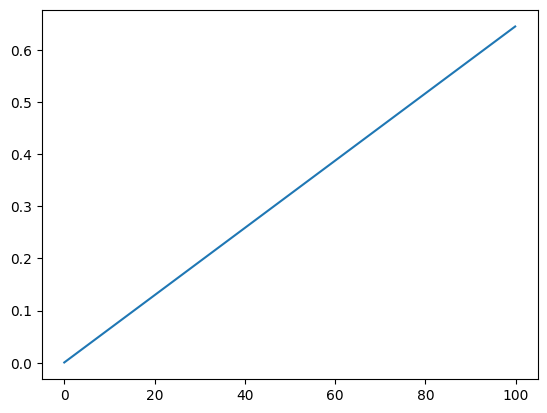

In [47]:
plt.figure()
plt.plot(percentiles, gmt_cumulative)

plt.show()